# Covid-19 Hospitalization Challenge

The dataset contains information about Covid-19 patients admitted to the hospital and gives information about whether they died at the hospital or survived. It includes information about the patients like their comorbidities, their vital signs and their smoking history. This notebook will focus on 2 major aspects,

   1. Exploratory data analysis to find interesting insights.
   2. Building a machine learning model to predict if a COVID patient is likely to die when admitted to the hospital.

In [6546]:
#importing libraries

import pandas as pd
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import re

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif,RFE, RFECV
import numpy as np
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression


# libaries to help with data visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Overview of the dataset

In [6547]:
df = pd.read_csv("../data/challenge_data/covid_hospitalization_dataset.csv")

In [6548]:
df

,age,sex,height,weight,comorbidities,smoking_history,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,...,sodium,potassium,total_serum_bilirubin,lactate,did_the_patient_die_in_hospital,hospital_length_of_stay,icu_length_of_stay,days_in_hospital_prior_to_icu_admission,time_on_mechanical_ventilation,days_in_hospital_prior_to_mechanical_ventilation
0,74,Male,NaN,NaN,"['Hypertension', 'Diabetes', 'Other']",NaN,No,WARD,99.0,62.0,...,135.0,3.9,10.0,2.3,Yes,21,NaN,NaN,NaN,NaN
1,61,Female,154.9,73.6,"['Hypertension', 'Other']",NaN,No,WARD,122.0,77.0,...,137.0,3.8,12.0,1.5,No,5,NaN,NaN,NaN,NaN
2,58,Female,NaN,NaN,['Hypertension'],NaN,No,WARD,109.0,72.0,...,135.0,3.7,7.0,1.0,No,7,NaN,NaN,NaN,NaN
3,94,Male,182.8,66.2,"['Hypertension', 'Other']",NaN,No,WARD,165.0,71.0,...,135.0,2.8,10.0,4.5,Yes,9,NaN,NaN,NaN,NaN
4,91,Male,NaN,NaN,"['Chronic cardiac disease (not hypertension)',...",Ex-smoker,No,WARD,131.0,76.0,...,142.0,3.8,19.0,3.2,Yes,9,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,32,Female,NaN,NaN,[],Non-smoker,No,WARD,101.0,83.0,...,140.0,3.8,166.0,NaN,No,7,NaN,NaN,NaN,NaN
697,65,Male,NaN,NaN,"['Hypertension', 'Diabetes']",Non-smoker,No,WARD,104.0,51.0,...,127.0,4.7,NaN,NaN,No,8,NaN,NaN,NaN,NaN
698,60,Male,NaN,NaN,['Hypertension'],Non-smoker,No,ICU,150.0,70.0,...,137.0,4.0,NaN,NaN,No,2,NaN,NaN,NaN,NaN
699,63,Male,NaN,NaN,"['Diabetes', 'Other']",Non-smoker,No,ICU,157.0,102.0,...,139.0,5.2,NaN,NaN,No,61,61.0,NaN,NaN,NaN


In [6549]:
def data_type_statistics(df):
    
    ''' Provides information about the data types present in the dataset'''

    data_types = pd.DataFrame(df.dtypes)
    data_types = data_types.reset_index()
    data_types.columns = ['Columns', 'Data Types']
    # get data type value counts
    data_type_distribution = pd.DataFrame(data_types['Data Types'].value_counts())
    data_type_distribution = data_type_distribution.reset_index()
    data_type_distribution.columns = ['Data Types', '# of Features']
    display(data_type_distribution)

In [6550]:
def missing_data_statistics(df, return_stats_df, plot = True, threshold = 30 ):
    
    ''' Provides missing data statistics for all the features in the dataset'''

    missing_values = pd.DataFrame(df.isnull().sum())
    missing_values = missing_values.reset_index()
    # get # of missing values in each columns
    missing_values.columns = ['Columns', 'Missing Values']
    # get % of missing values in each columns
    missing_values['% of Missing Values'] = round((missing_values['Missing Values']/len(df)) * 100, 2)
    # calculate missing cells
    missing_cells = missing_values['Missing Values'].sum()
    rows, columns = df.shape[0], df.shape[1]
    total_cells = int(rows * columns)
    missing_cells_percentage = missing_cells/total_cells
    # find features with missing values above a certain threshold
    features_with_missing_values = missing_values[missing_values['Missing Values']> 0]
    features_with_missing_values_count = len(features_with_missing_values)
    features_with_missing_values_above_threshold = missing_values[missing_values['% of Missing Values']> threshold]
    features_with_missing_values_above_threshold = len(features_with_missing_values_above_threshold)

    print("Missing Cells:", missing_cells)
    print("Missing Cells(%): {:.2%}".format(missing_cells_percentage))
    print("# of features with missing values:", features_with_missing_values_count)
    print("# of features with more than {}% of missing values:".format(threshold), features_with_missing_values_above_threshold)
    
    if plot == True:
        missing_values.plot.bar(x="Columns", subplots=True, figsize = (20,5))
    
    # Return the missing value statistics dataframe
    if return_stats_df == True:
        return features_with_missing_values

In [6551]:
def print_data_shape(df):

    ''' Prints the shape of the dataframe'''

    rows = df.shape[0]
    columns = df.shape[1]
    
    print("# of data samples:", rows)
    print("# of columns:", columns)

In [6552]:
def get_dataset_statistics(df, target_variable):

    '''Provides overall statistics for the dataframe'''
    
    #print dataframe shape
    print_data_shape(df)

    #calculate duplicate values

    duplicate_row_count = df.duplicated().sum()
    duplicate_row_percent = duplicate_row_count / len(df)
    
    print("Duplicate rows", duplicate_row_count )
    print("Duplicate rows(%): {:.2%}".format(duplicate_row_percent))
    
    #calculate data type statistics

    data_type_statistics(df)

    print("Target Variable Distribution")
    target_variable_distribution = pd.DataFrame(df[target_variable].value_counts())
    target_variable_distribution = target_variable_distribution.reset_index()
    target_variable_distribution.columns = ['Target Label', '# of Samples']
    target_variable_distribution['% of Samples'] = round((target_variable_distribution['# of Samples']/len(df)) * 100, 2)

    display(target_variable_distribution)
    sns.countplot(x = df[target_variable], palette="pastel")

    missing_data_statistics(df, return_stats_df = False, threshold = 30)

# of data samples: 701
# of columns: 41
Duplicate rows 0
Duplicate rows(%): 0.00%


,Data Types,# of Features
0,float64,32
1,object,7
2,int64,2


Target Variable Distribution


,Target Label,# of Samples,% of Samples
0,No,583,83.17
1,Yes,118,16.83


Missing Cells: 5249
Missing Cells(%): 18.26%
# of features with missing values: 37
# of features with more than 30% of missing values: 11


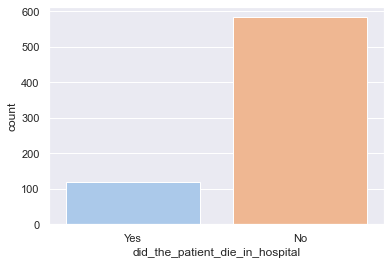

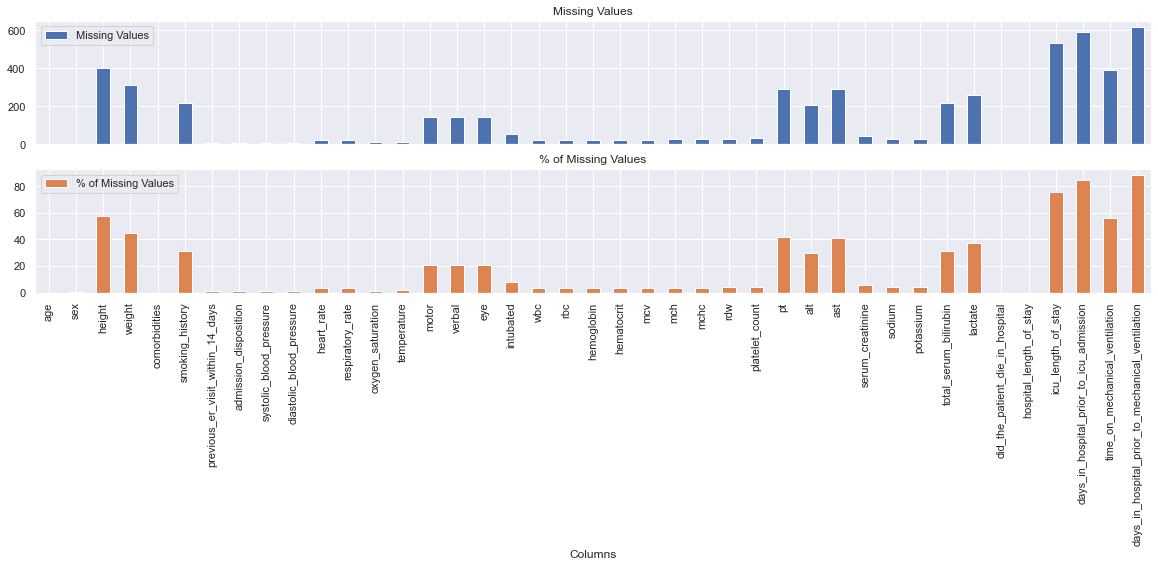

In [6553]:
# Provides an overview of the dataframe
get_dataset_statistics(df, "did_the_patient_die_in_hospital")

Let's analyze the distribution of the numerical features

In [6554]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,701.0,66.457917,17.341940,18.00,56.000,68.000,80.000,100.000
height,297.0,166.931987,10.798881,125.00,159.000,167.600,175.000,198.000
weight,388.0,80.095619,21.381694,27.70,65.800,76.300,89.825,199.600
systolic_blood_pressure,694.0,130.064841,22.553003,74.00,115.000,128.000,144.000,230.000
diastolic_blood_pressure,693.0,75.196248,13.267006,22.00,67.000,75.000,83.000,145.000
heart_rate,677.0,95.774003,18.588682,41.00,83.000,96.000,107.000,199.000
respiratory_rate,679.0,23.998527,7.153088,12.00,20.000,22.000,28.000,59.000
oxygen_saturation,691.0,93.178003,6.930410,3.00,92.000,95.000,96.000,100.000
temperature,688.0,37.606890,1.083962,26.80,36.800,37.500,38.400,40.500
motor,557.0,5.831239,0.763531,1.00,6.000,6.000,6.000,6.000


## Observations:

Based on the initial analysis the following can be concluded about the data,

<div class="alert alert-block alert-info"> 📌 It is a highly imbalanced dataset with the labels distributed as 83% and 17%.</div>
<div class="alert alert-block alert-info"> 📌 Several features in the dataset contains missing values.</div>
<div class="alert alert-block alert-info"> 📌 There are a few features with around 80% of missing data. Upon further exploration, the features have been identifed as data which cannot be obtained when the patient is being admitted to the hospital.</div>
<!-- <div class="alert alert-block alert-info"> 📌 Please note that class="alert alert-block alert-info" is a pre-defined class by kaggle and we are simply using it in our notebook.</div> -->
<!--     1. It is a highly imbalanced dataset with the labels distributed as 83% and 17%.
    2. Several features in the dataset contains missing values.
    3. The dataset contains few outliers which needs to be explored.
    4. There are a few features with around 80% of missing data. Upon further exploration, the features have been identifed as data which cannot be obtained when the patient is being admitted to the hospital.
 -->

The goal of this challenge is to build a model to predict if a COVID patient is likely to die **when admitted to the hospital**. We can separate the features for which the data cannot be obtained when the patient is being admitted to the hospital. These features can be used for the exploratory data analysis but they have to ignored while building the model. The following are the features,

    1. hospital_length_of_stay
    2. icu_length_of_stay
    3. days_in_hospital_prior_to_icu_admission
    4. time_on_mechanical_ventilation
    5. days_in_hospital_prior_to_mechanical_ventilation

# Exploratory Data Analysis:

The main goals of the exploratory data analysis are as follows,

    1. Are there any leading indicators of Covid-19 deaths?
    2. Univariate and Multivariate Analysis

## Leading Indicators of Covid Deaths:

Are there any features which are the leading indicators of Covid deaths?

1. Does age has an impact on Covid deaths?
2. Out of the 18 comorbidities present in the patients, what are the top ones associated with death? (Bonus Task)
3. Is low platelet count an indicator of Covid deaths?
4. Is WBC count an indicator of Covid deaths?

Let's jump into the analysis to find out the answers to these questions.

### Are there any leading indicators of Covid-19 deaths?

#### 1. Does age has an impact on Covid deaths?  

To analyze the distribution of age, it can be bucketed into various bins. The following table shows the binning of various age groups for analysis,


|        Age Range       |     Bucket    |
| ---------------------- | ------------- |
| Less than 18 years old |    Infants    |
|   18 to 30 years old   |  Young Adults |
|   30 to 45 years old   |     Adults    |
|   45 to 60 years old   | Senior Adults |
|   60 to 80 years old   |      Old      |
| More than 80 years old |    Very Old   |

In [6555]:
# Function to bin age groups
def age_bins(x):
    
    '''Assigns a relevant age bucket'''
    
    if x < 18:
        return "Infants"
    elif x < 30:
        return "Young Adults"
    elif x < 45:
        return "Adults"
    elif x < 60:
        return "Senior Adults"
    elif x < 80:
        return "Old"
    else:
        return "Very Old"
    
df['age_bins'] = df['age'].apply(lambda x: age_bins(x))

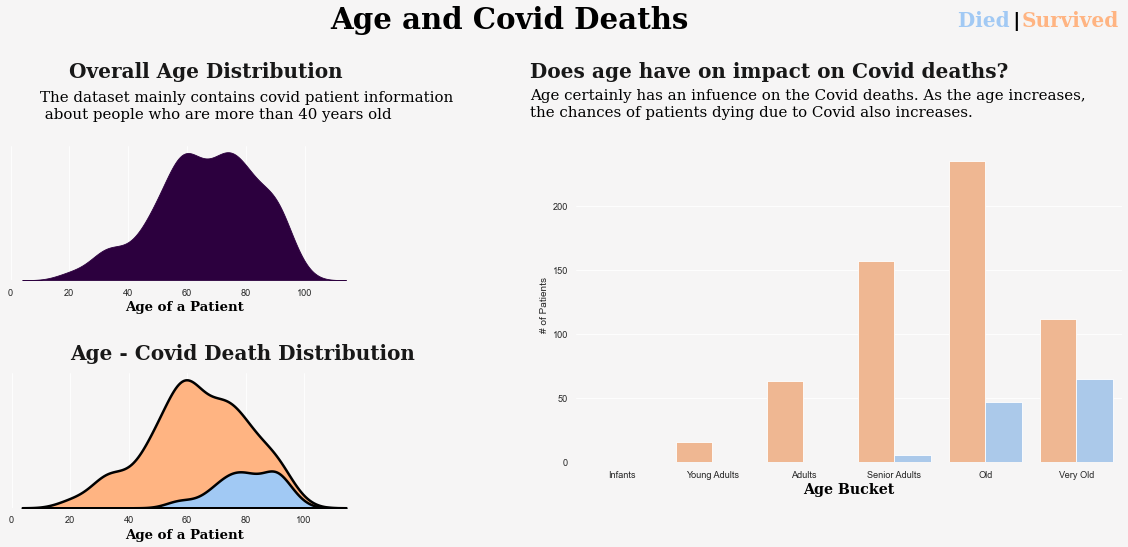

In [6556]:
fig = plt.figure(figsize = (24, 10), dpi = 60)

gs = fig.add_gridspec(10,24)
gs.update(wspace = 1, hspace = 0.05)


ax2 = fig.add_subplot(gs[1:4,0:8]) #distribution plot
ax3 = fig.add_subplot(gs[6:9, 0:8]) #hue distribution plot
ax1 = fig.add_subplot(gs[1:8,12:]) # bar plot

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f6f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

fig.patch.set_facecolor('#f6f5f5')
        
ax1.axes.get_xaxis().set_visible(True)
ax1.axes.get_yaxis().set_visible(True)

# Bar plot Age and Covid Deaths

crosstab_df = pd.crosstab(df['age_bins'],df['did_the_patient_die_in_hospital'])
stacked = crosstab_df.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked['age_bins'], y=stacked.value, hue=stacked['did_the_patient_die_in_hospital'],
            ax = ax1, 
            order=['Infants','Young Adults','Adults','Senior Adults','Old','Very Old'], 
            palette= {'Yes': '#a1c9f4', 'No': '#ffb482'}).legend().remove()

ax1.set(xlabel = '',ylabel = '# of Patients')

ax1.text(-1,300, 'Does age have on impact on Covid deaths?' ,{'font': 'Serif', 'Size': '24','weight':'bold', 'color':'black'},alpha = 0.9)
ax1.text(-1,270, 'Age certainly has an infuence on the Covid deaths. As the age increases, \nthe chances of patients dying due to Covid also increases.', 
        {'font':'Serif', 'size':'18','color': 'black'})
ax1.text(3.7,340, 'Died ', {'font': 'Serif','weight':'bold','Size': '24','weight':'bold','style':'normal', 'color':'#a1c9f4'})
ax1.text(4.3,340, '|', {'color':'black' , 'size':'24', 'weight': 'bold'})
ax1.text(4.4,340, 'Survived', {'font': 'Serif','weight':'bold', 'Size': '24','style':'normal', 'weight':'bold','color':'#ffb482'})
ax1.set_xlabel('Age Bucket', fontdict = {'font':'Serif', 'color': 'black', 'size': 17,'weight':'bold' })


# distribution plots ---- only single variable

sns.kdeplot(data = df, x = 'age', ax = ax2, shade = True, color = '#2c003e', alpha = 1, ).set_title(None)
ax2.set_xlabel('Age of a Patient', fontdict = {'font':'Serif', 'color': 'black', 'size': 16,'weight':'bold' })
ax2.text(20,0.0325,'Overall Age Distribution', {'font':'Serif', 'color': 'black','weight':'bold','size':24}, alpha = 0.9)
ax2.text(10,0.0260, 'The dataset mainly contains covid patient information \n about people who are more than 40 years old', 
        {'font':'Serif', 'size':'18','color': 'black'})


# distribution plots with hue of covid deaths

sns.kdeplot(data = df, x = 'age', shade = True, hue = "did_the_patient_die_in_hospital",ax = ax3, palette="pastel", alpha = 1,linewidth = 3, ec = 'black', legend = False ).set_title(None)
ax3.set_xlabel('Age of a Patient', fontdict = {'font':'Serif', 'color': 'black', 'weight':'bold','size': 16})

ax3.text(20,0.022,'Age - Covid Death Distribution', {'font':'Serif', 'weight':'bold','color': 'black', 'size':24}, alpha= 0.9)

fig.text(0.35,1,'Age and Covid Deaths',{'font':'Serif', 'weight':'bold','color': 'black', 'size':35})
fig.show()

<div class="alert alert-block alert-info"> 📌 Based on our analysis, it is evident that age plays a crucial role and has big impact on the death of Covid-19 patients. People above 60 years old are more likely to die from Covid-19 when admitted to the hospital.</div>


#### 2. Does certain comorbidities or combination of comorbidities lead to increased Covid deaths? (Bonus Task):

The comorbidities are present as string of list values.

In [6557]:
comorbidities_df = df[['comorbidities','did_the_patient_die_in_hospital']]
print(comorbidities_df['comorbidities'].value_counts()[:10])

[]                                                                                     91
['Other']                                                                              75
['Hypertension', 'Other']                                                              62
['Hypertension', 'Diabetes', 'Other']                                                  44
['Hypertension']                                                                       24
['Chronic cardiac disease (not hypertension)', 'Hypertension', 'Diabetes', 'Other']    21
['Diabetes', 'Other']                                                                  17
['Chronic cardiac disease (not hypertension)', 'Hypertension', 'Other']                14
['Hypertension', 'Diabetes']                                                           14
['Asthma', 'Other']                                                                    12
Name: comorbidities, dtype: int64


To find the effect of individual comorbiditiy on the death of Covid patients, the comorbidities column has to expanded into one hot encoded style columns. It can be achieved using the Multi label encoder function from the scikit learn library. The following function expands the comorbidities into individual columns.

**Before expansion**

In [6558]:
comorbidities_df

,comorbidities,did_the_patient_die_in_hospital
0,"['Hypertension', 'Diabetes', 'Other']",Yes
1,"['Hypertension', 'Other']",No
2,['Hypertension'],No
3,"['Hypertension', 'Other']",Yes
4,"['Chronic cardiac disease (not hypertension)',...",Yes
...,...,...
696,[],No
697,"['Hypertension', 'Diabetes']",No
698,['Hypertension'],No
699,"['Diabetes', 'Other']",No


In [6559]:
def clean_column_names(column):

    '''Converts column names to snake_case: Chronic Cardiac Disease -> chronic_cardiac_disease'''

    column = column.rstrip()
    column = re.sub(r'\[.*?\]', '', column)
    column = re.sub(r'\(.*?\)','', column)
    column = re.sub('  ',' ', column)

    return column.strip().lower().replace(' ', '_')

def verify_column_expansion(df, df_expanded, column):
    
    '''Verifies if the columns are correctly expanded'''

    df['column_length'] = df[column].apply(len)
    df_expanded['expanded_count'] = df_expanded.sum(axis = 1)
    merged = pd.merge(df_expanded, df, left_index = True, right_index = True, how = 'inner')
    matching_comorbidities = merged[merged['expanded_count'] == merged['column_length']]
    mismatch = merged[merged['expanded_count'] != merged['column_length']]
    
    print("Correct expanded rows:", matching_comorbidities.shape[0])
    print("Incorrectly expanded rows:", mismatch.shape[0])
    
    if matching_comorbidities.shape[0] == df.shape[0]:
        print("The column has been expanded without any errors")
        return True
    else:
        print("Error: Mismatch in expanded value's length!")
        return False

def expand_columns_with_list(df, column, expansion_stats = False):
    
    '''Expands columns with list values into separate columns with binary labels'''
    
    df[column] = df[column].apply(eval)
    mlb = MultiLabelBinarizer()
    df_expanded = pd.DataFrame(mlb.fit_transform(df[column]), columns = mlb.classes_, index = df.index)
    df_expanded.columns = [ clean_column_names(column) for column in list(df_expanded.columns)]
    expanded_column_list = list(df_expanded.columns)
    df = pd.merge(df_expanded, df, left_index = True, right_index = True, how = 'inner')
    expansion_status = verify_column_expansion(df, df_expanded, column)
    df = df.drop(['column_length',column], axis = 1)
    if expansion_status:
        return df

In [6560]:
comorbidities_df = expand_columns_with_list(comorbidities_df, 'comorbidities')

Correct expanded rows: 701
Incorrectly expanded rows: 0
The column has been expanded without any errors


**After Expansion**

In [6561]:
comorbidities_df

,asthma,cancer,chronic_cardiac_disease,chronic_neurological_disorder,chronic_pulmonary_disease,chronic_renal,dementia,diabetes,hematological,history_of_cancer,hypertension,kidney_disease,liver_disease,obesity,other,pregnancy,rheumatologic_disorder,stroke,did_the_patient_die_in_hospital
0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,Yes
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,No
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,No
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,Yes
4,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No
697,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,No
698,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,No
699,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,No


**Distribution of Comorbidities**

In [6562]:
comorbidities_all = pd.DataFrame(comorbidities_df_expanded.sum())
comorbidities_all = comorbidities_all.reset_index()
comorbidities_all.columns = ['Comorbidity', '# of Patients']
comorbidities_all = comorbidities_all.sort_values('# of Patients', ascending = False)
comorbidities_all['Comorbidity'] = comorbidities_all['Comorbidity'].str.replace('_',' ')
comorbidities_all['Comorbidity'] = comorbidities_all['Comorbidity'].str.title()
comorbidities_all['% of Patients'] = round((comorbidities_all['# of Patients']/len(comorbidities_df_expanded)) * 100, 2)

comorbidities_all[:5]

,Comorbidity,# of Patients,% of Patients
14,Other,501,71.47
10,Hypertension,394,56.21
7,Diabetes,229,32.67
2,Chronic Cardiac Disease,127,18.12
0,Asthma,68,9.70


Other comorbidities (comorbidities which are not listed in the dataset), hypertension and diabeters are the 3 most commonly occuring comorbidities among all the Covid patients.

**Distribution of deaths based on comorbidities**

In [6563]:
dead_patients = comorbidities_df[comorbidities_df['did_the_patient_die_in_hospital'] == 'Yes']
dead_patients = dead_patients.drop(['did_the_patient_die_in_hospital'], axis=1)
dead_patients_comorbidities = pd.DataFrame(dead_patients.sum())
dead_patients_comorbidities = dead_patients_comorbidities.reset_index()
dead_patients_comorbidities.columns = ['Comorbidity', '# of Covid-19 Deaths']
dead_patients_comorbidities = dead_patients_comorbidities.sort_values('# of Covid-19 Deaths', ascending = False)
dead_patients_comorbidities['Comorbidity'] = dead_patients_comorbidities['Comorbidity'].str.replace('_',' ')
dead_patients_comorbidities['Comorbidity'] = dead_patients_comorbidities['Comorbidity'].str.title()
dead_patients_comorbidities['% of Covid-19 Deaths'] = round((dead_patients_comorbidities['# of Covid-19 Deaths']/len(dead_patients)) * 100, 2)

dead_patients_comorbidities[:5]

,Comorbidity,# of Covid-19 Deaths,% of Covid-19 Deaths
14,Other,105,88.98
10,Hypertension,94,79.66
7,Diabetes,54,45.76
2,Chronic Cardiac Disease,44,37.29
6,Dementia,20,16.95


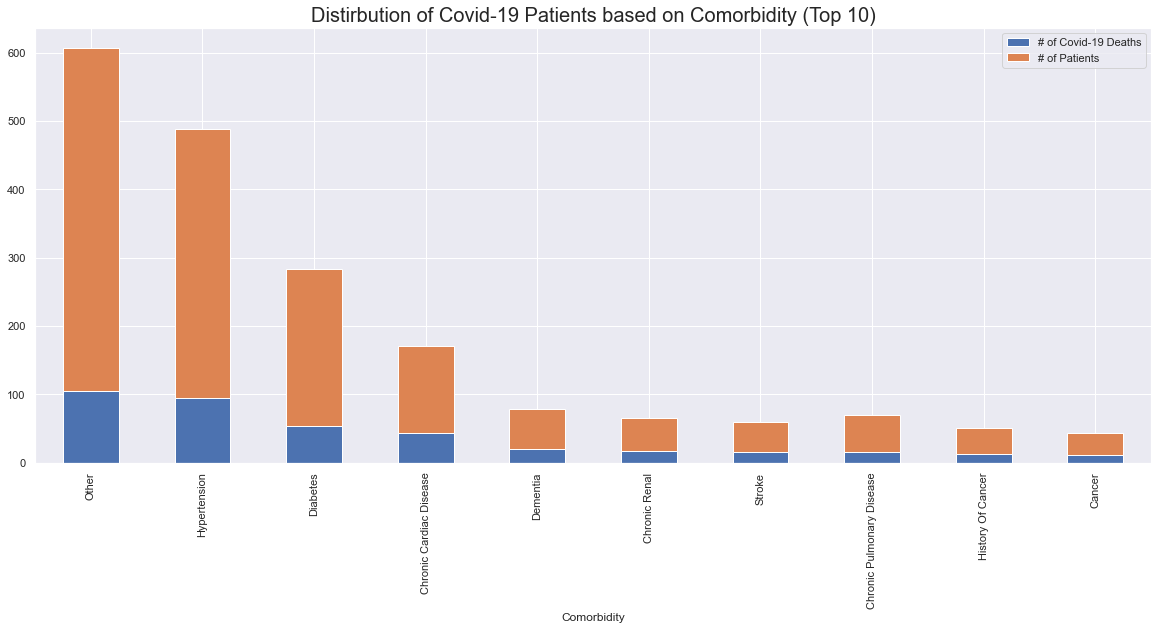

In [6564]:
comorbidities_analysis = pd.merge(dead_patients_comorbidities, comorbidities_all, on = 'Comorbidity', how = 'inner' )
comorbidities_analysis = comorbidities_analysis[['Comorbidity', '# of Covid-19 Deaths', '# of Patients']]
comorbidities_analysis[['Comorbidity', '# of Covid-19 Deaths', '# of Patients']][:10].plot(x = "Comorbidity", kind='bar', stacked=True, figsize = (20,8))
plt.title("Distirbution of Covid-19 Patients based on Comorbidity (Top 10)", size = 20)
plt.show()

<div class="alert alert-block alert-info"> 📌📌 A single patient can have many comorbidities. Based on our analysis, the 3 most commonly occuring comorbidities which are associated with 118 patients who died after admitted are,
    <br>

1. Other comorbidities which are not listed in the sample
2. Hypertension 
3. Diabetes

But are these the deadlist comorbidities? We need to find out the **death rate** of each comorbidity. Let's find out... </div>



**Death rate of comorbidities**

In [6565]:
comorbidities_analysis['Comorbidity Death Rate'] = round((comorbidities_analysis['# of Covid-19 Deaths']/ comorbidities_analysis['# of Patients']) * 100, 2)
comorbidities_analysis = comorbidities_analysis.sort_values('Comorbidity Death Rate', ascending = False)
comorbidities_analysis[:5]


,Comorbidity,# of Covid-19 Deaths,# of Patients,Comorbidity Death Rate
10,Chronic Neurological Disorder,8,22,36.36
5,Chronic Renal,17,48,35.42
3,Chronic Cardiac Disease,44,127,34.65
9,Cancer,11,32,34.38
4,Dementia,20,59,33.90


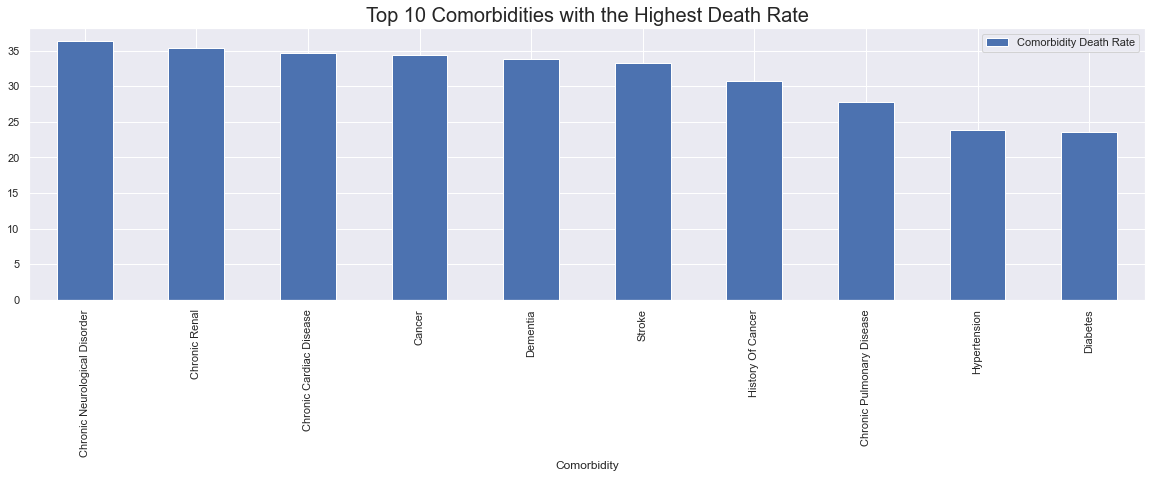

In [6566]:
comorbidities_analysis[['Comorbidity','Comorbidity Death Rate']][:10].plot.bar(x = "Comorbidity", subplots=True, figsize = (20,5))
plt.title("Top 10 Comorbidities with the Highest Death Rate", size = 20)
plt.show()

<div class="alert alert-block alert-info"> 📌📌 
   Comorbidities with the top 3 highest death rates:
    <br>
    
    1. Chronic Neurological Disorder
    2. Chronic Renal
    3. Chronic Cardiac Disease
    
   Chronic Neurological Disorder, Chronic Renal and Chronic Cardiac Disease are the comorbidities with the top 3 highest death rates. It means that if a Covid patient is admitted to a hospital with one of these 3 comorbidities, the patient is more likely to die compared to patients who have only other comorbidities or only hyperension. </div>

#### Death rates of multiple comorbidities

In [6567]:
multiple_comorbidities = df[['comorbidities','did_the_patient_die_in_hospital']]
multiple_comorbidities['comorbidities'] = multiple_comorbidities['comorbidities'].str.replace('[', '')
multiple_comorbidities['comorbidities'] = multiple_comorbidities['comorbidities'].str.replace(']', '')
multiple_comorbidities['comorbidities'] = multiple_comorbidities['comorbidities'].str.strip()
multiple_comorbidities['comorbidities'] = multiple_comorbidities[multiple_comorbidities['comorbidities']!= '']
multiple_comorbidities = multiple_comorbidities.dropna()
multiple_comorbidities['# of Patients'] = multiple_comorbidities.groupby(['comorbidities'])['comorbidities'].transform('count')
multiple_comorbidities_count = multiple_comorbidities[['comorbidities','# of Patients']].drop_duplicates()
multiple_comorbidities_dead =  multiple_comorbidities[multiple_comorbidities['did_the_patient_die_in_hospital'] == 1]
multiple_comorbidities_dead_count = pd.DataFrame(multiple_comorbidities_dead['comorbidities'].value_counts()).reset_index()
multiple_comorbidities_dead_count.columns = ['comorbidities', '# of Covid Deaths']
multiple_comorbidities_count = pd.merge(multiple_comorbidities_count,multiple_comorbidities_dead_count, on = 'comorbidities', how = 'left' )
multiple_comorbidities_count = multiple_comorbidities_count.fillna(0)
multiple_comorbidities_count['# of Covid Deaths'] = multiple_comorbidities_count['# of Covid Deaths'].apply(int)
multiple_comorbidities_count['Comorbidity Death Rate(%)'] = round(multiple_comorbidities_count['# of Covid Deaths']/multiple_comorbidities_count['# of Patients'] *100, 2)
multiple_comorbidities_count = multiple_comorbidities_count.sort_values(['# of Covid Deaths','Comorbidity Death Rate(%)'], ascending = [False,False])
multiple_comorbidities_count[:5]

,comorbidities,# of Patients,# of Covid Deaths,Comorbidity Death Rate(%)
0,"'Hypertension', 'Diabetes', 'Other'",44,0,0.0
1,"'Hypertension', 'Other'",62,0,0.0
2,'Hypertension',24,0,0.0
3,"'Chronic cardiac disease (not hypertension)', ...",21,0,0.0
4,"'Chronic cardiac disease (not hypertension)', ...",1,0,0.0


In [6568]:
multiple_comorbidities_count['comorbidities'].values.tolist()[:5]

["'Hypertension', 'Diabetes', 'Other'",
 "'Hypertension', 'Other'",
 "'Hypertension'",
 "'Chronic cardiac disease (not hypertension)', 'Hypertension', 'Diabetes', 'Other'",
 "'Chronic cardiac disease (not hypertension)', 'Hypertension', 'Chronic pulmonary (lung) disease', 'Kidney disease', 'Diabetes', 'Other'"]

<div class="alert alert-block alert-info"> 📌📌 Chronic cardiac disease (not hypertension)', 'Hypertension', 'Diabetes', 'Other' comorbidity combination seems have the highest death rate with atleast 10 deaths.</div>

**Does having multiple comorbidities leads to increased deaths?**

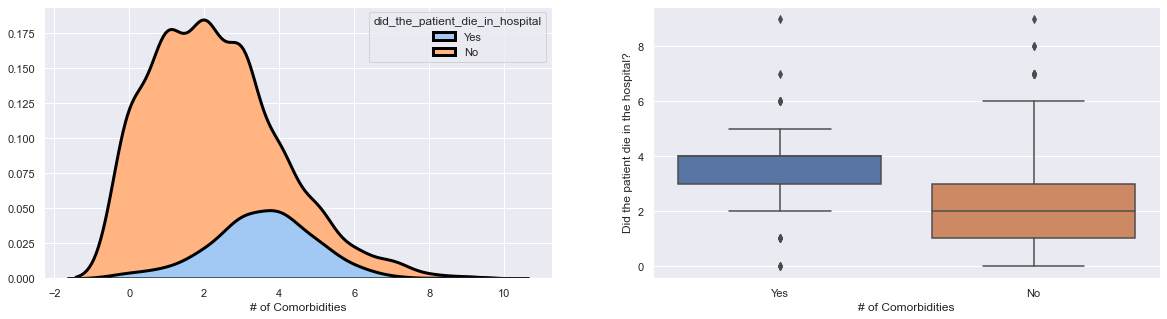

In [6569]:
comorbidities_df['comorbidities_count'] = comorbidities_df.sum(axis=1)

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))
#fig.patch.set_facecolor(colors[-1])
axes = ax.ravel()
sns.kdeplot(data = comorbidities_df, x = 'comorbidities_count', shade = True, 
            hue = "did_the_patient_die_in_hospital", palette="pastel",
            alpha = 1, linewidth = 3, ec = 'black', ax = axes[0])
axes[0].set(xlabel = '# of Comorbidities',ylabel = '')

sns.boxplot(data= comorbidities_df, y="comorbidities_count", x="did_the_patient_die_in_hospital", ax = axes[1])
axes[1].set(xlabel = '# of Comorbidities',ylabel = 'Did the patient die in the hospital?')
plt.show()


<div class="alert alert-block alert-info"> 📌 People with more comorbidities are more like to die due to Covid after being admitted to the hospital.
   </div>


#### Is low platelet count an indicator of Covid deaths?

To analyze the distribution of platelet count, it can be bucketed into various bins based on standards followed in the medical industry. The following table shows the binning of the platelet count for analysis,


|  Platelet Count Range  |     Bucket         |
| ---------------------- | ------------------ |
|Less than 150 x $10^9$/L| Low Platelet Count |
|  150 - 400 x $10^9$/L  |    Normal Range    |
|More than 400 x $10^9$/L|High Platelet Count |


In [6570]:
def platelet_bins(x):
    if x < 150:
        return "Low Platelet Count"
    elif x < 400:
        return "Normal Range"
    else: 
        return "High Platelet Count"

df['platelet_bins'] = df['platelet_count'].apply(lambda x: platelet_bins(x))

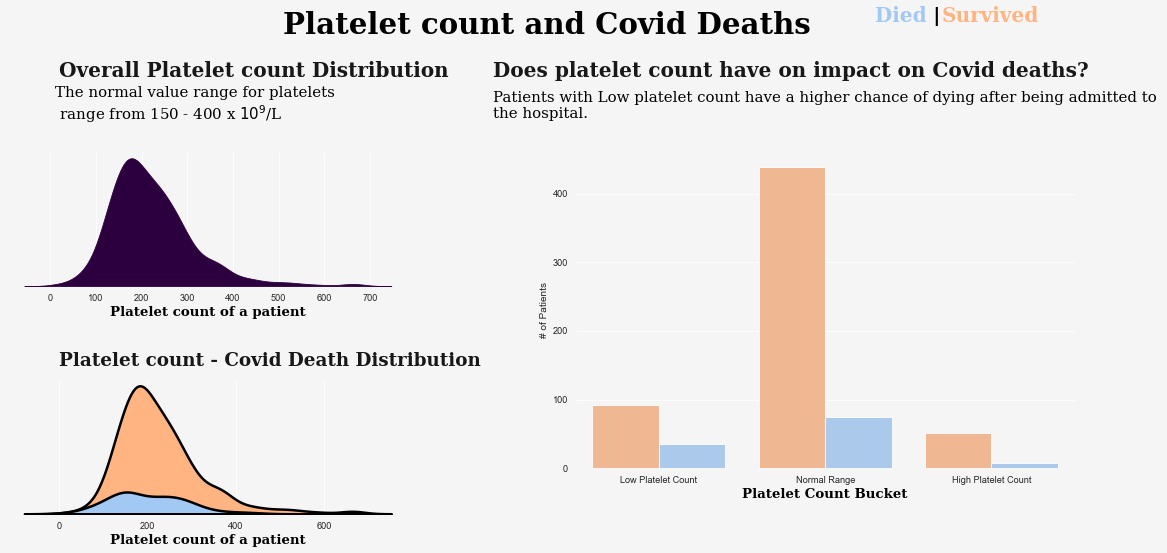

In [6571]:
fig = plt.figure(figsize = (24, 10), dpi = 60)

gs = fig.add_gridspec(10,24)
gs.update(wspace = 1, hspace = 0.05)


ax2 = fig.add_subplot(gs[1:4,1:10]) #distribution plot
ax3 = fig.add_subplot(gs[6:9, 1:10]) #hue distribution plot
ax1 = fig.add_subplot(gs[1:8,13:]) # bar plot

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f6f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

fig.patch.set_facecolor('#f6f5f5')
        
ax1.axes.get_xaxis().set_visible(True)
ax1.axes.get_yaxis().set_visible(True)

# Bar plot Platelet count and Covid Deaths

crosstab_df = pd.crosstab(df['platelet_bins'],df['did_the_patient_die_in_hospital'])
stacked = crosstab_df.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked['platelet_bins'], y=stacked.value, hue=stacked['did_the_patient_die_in_hospital'],
            ax = ax1, 
            order=['Low Platelet Count','Normal Range','High Platelet Count'], 
            palette= {'Yes': '#a1c9f4', 'No': '#ffb482'}).legend().remove()

ax1.set(xlabel = '',ylabel = '# of Patients')

ax1.text(-1,570, 'Does platelet count have on impact on Covid deaths?' ,{'font': 'Serif', 'Size': '24','weight':'bold', 'color':'black'},alpha = 0.9)
ax1.text(-1,510, 'Patients with Low platelet count have a higher chance of dying after being admitted to \nthe hospital.', 
        {'font':'Serif', 'size':'18','color': 'black'})
ax1.text(1.3,650, 'Died ', {'font': 'Serif','weight':'bold','Size': '24','weight':'bold','style':'normal', 'color':'#a1c9f4'})
ax1.text(1.65,650, '|', {'color':'black' , 'size':'24', 'weight': 'bold'})
ax1.text(1.70,650, 'Survived', {'font': 'Serif','weight':'bold', 'Size': '24','style':'normal', 'weight':'bold','color':'#ffb482'})
ax1.set_xlabel('Platelet Count Bucket', fontdict = {'font':'Serif', 'color': 'black', 'size': 16,'weight':'bold' })


# distribution plots ---- only single variable

sns.kdeplot(data = df, x = 'platelet_count', ax = ax2, shade = True, color = '#2c003e', alpha = 1, ).set_title(None)
ax2.set_xlabel('Platelet count of a patient', fontdict = {'font':'Serif', 'color': 'black', 'size': 16,'weight':'bold' })
ax2.text(20,0.008550,'Overall Platelet count Distribution', {'font':'Serif', 'color': 'black','weight':'bold','size':24}, alpha = 0.9)
ax2.text(10,0.0068, 'The normal value range for platelets \n range from 150 - 400 x $10^9$/L', 
        {'font':'Serif', 'size':'18','color': 'black'})


# distribution plots with hue of covid deaths

sns.kdeplot(data = df, x = 'platelet_count', shade = True, hue = "did_the_patient_die_in_hospital",ax = ax3, palette="pastel", alpha = 1,linewidth = 3, ec = 'black', legend = False ).set_title(None)
ax3.set_xlabel('Platelet count of a patient', fontdict = {'font':'Serif', 'color': 'black', 'weight':'bold','size': 16})

ax3.text(1,0.0052,'Platelet count - Covid Death Distribution', {'font':'Serif', 'weight':'bold','color': 'black', 'size':22}, alpha= 0.9)

fig.text(0.35,1,'Platelet count and Covid Deaths',{'font':'Serif', 'weight':'bold','color': 'black', 'size':35})
fig.show()

Additional visualizations are required to say that low platelet count is an indicator of Covid deaths. A box plot can be used for this purpose.

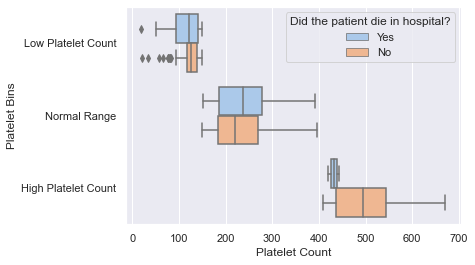

In [6572]:
sns.boxplot(data = df, x = "platelet_count", y="platelet_bins", hue="did_the_patient_die_in_hospital", palette = "pastel").legend(title = 'Did the patient die in hospital?')
plt.xlabel("Platelet Count")
plt.ylabel("Platelet Bins")
plt.show()

<div class="alert alert-block alert-info"> 📌 Based on the visualizations, platelet count is an indicator of a Covid patient dying after being admitted to the hospital.
   </div>

#### Is WBC count an indicator of Covid deaths?

To analyze the distribution of WBC count, it can be bucketed into various bins based on standards followed in the medical industry. The following table shows the binning of the WBC count for analysis,


|  WBC Count Range       |     Bucket         |
| ---------------------- | ------------------ |
|Less than 4.5 x $10^9$/L|    Low WBC Count   |
|  4.5 - 11 x $10^9$/L   |    Normal Range    |
|More than 11 x $10^9$/L |   High WBC Count   |

In [6573]:
def wbc_bins(x):
    
    if x < 4.5:
        return "Low WBC Count"
    elif x < 11:
        return "Normal Range"
    else: 
        return "High WBC Count"

df['wbc_bins'] = df['wbc'].apply(lambda x: wbc_bins(x))

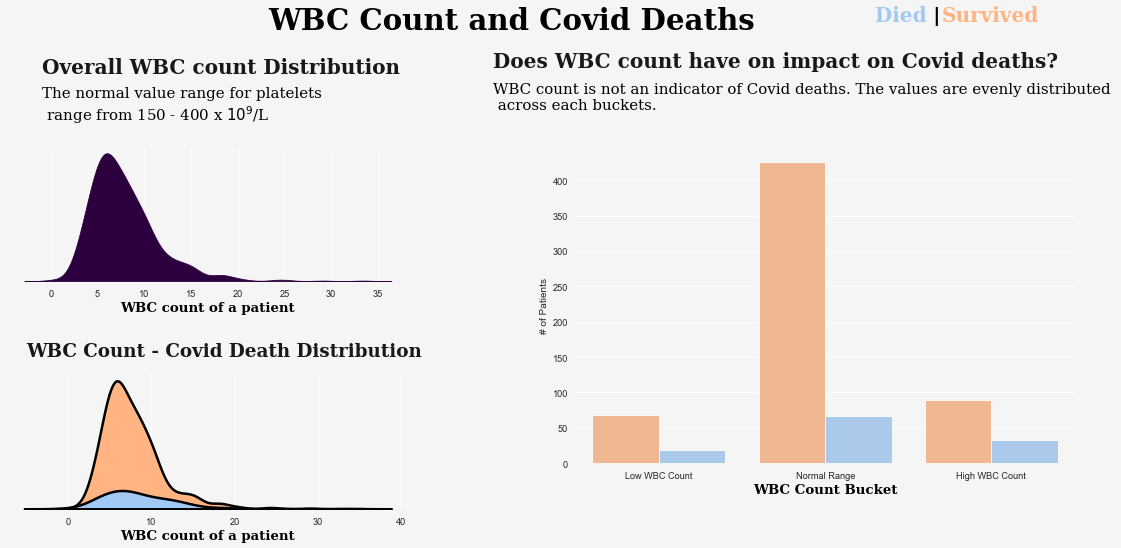

In [6574]:
fig = plt.figure(figsize = (24, 10), dpi = 60)

gs = fig.add_gridspec(10,24)
gs.update(wspace = 1, hspace = 0.05)


ax2 = fig.add_subplot(gs[1:4,1:10]) #distribution plot
ax3 = fig.add_subplot(gs[6:9, 1:10]) #hue distribution plot
ax1 = fig.add_subplot(gs[1:8,13:]) # bar plot

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f6f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

fig.patch.set_facecolor('#f6f5f5')
        
ax1.axes.get_xaxis().set_visible(True)
ax1.axes.get_yaxis().set_visible(True)

# Bar plot WBC count and Covid Deaths

crosstab_df = pd.crosstab(df['wbc_bins'],df['did_the_patient_die_in_hospital'])
stacked = crosstab_df.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x=stacked['wbc_bins'], y=stacked.value, hue=stacked['did_the_patient_die_in_hospital'],
            ax = ax1, 
            order=['Low WBC Count','Normal Range','High WBC Count'], 
            palette= {'Yes': '#a1c9f4', 'No': '#ffb482'}).legend().remove()

ax1.set(xlabel = '',ylabel = '# of Patients')

ax1.text(-1,560, 'Does WBC count have on impact on Covid deaths?' ,{'font': 'Serif', 'Size': '24','weight':'bold', 'color':'black'},alpha = 0.9)
ax1.text(-1,500, "WBC count is not an indicator of Covid deaths. The values are evenly distributed \n across each buckets.", 
        {'font':'Serif', 'size':'18','color': 'black'})
ax1.text(1.3,625, 'Died ', {'font': 'Serif','weight':'bold','Size': '24','weight':'bold','style':'normal', 'color':'#a1c9f4'})
ax1.text(1.65,625, '|', {'color':'black' , 'size':'24', 'weight': 'bold'})
ax1.text(1.70,625, 'Survived', {'font': 'Serif','weight':'bold', 'Size': '24','style':'normal', 'weight':'bold','color':'#ffb482'})
ax1.set_xlabel('WBC Count Bucket', fontdict = {'font':'Serif', 'color': 'black', 'size': 16,'weight':'bold' })


# distribution plots ---- only single variable

sns.kdeplot(data = df, x = 'wbc', ax = ax2, shade = True, color = '#2c003e', alpha = 1, ).set_title(None)
ax2.set_xlabel('WBC count of a patient', fontdict = {'font':'Serif', 'color': 'black', 'size': 16,'weight':'bold' })
ax2.text(-1,0.22,'Overall WBC count Distribution', {'font':'Serif', 'color': 'black','weight':'bold','size':24}, alpha = 0.9)
ax2.text(-1,0.17, 'The normal value range for platelets \n range from 150 - 400 x $10^9$/L', 
        {'font':'Serif', 'size':'18','color': 'black'})


# distribution plots with hue of covid deaths

sns.kdeplot(data = df, x = 'wbc', shade = True, hue = "did_the_patient_die_in_hospital",ax = ax3, palette="pastel", alpha = 1,linewidth = 3, ec = 'black', legend = False ).set_title(None)
ax3.set_xlabel('WBC count of a patient', fontdict = {'font':'Serif', 'color': 'black', 'weight':'bold','size': 16})

ax3.text(-5,0.14,'WBC Count - Covid Death Distribution', {'font':'Serif', 'weight':'bold','color': 'black', 'size':22}, alpha= 0.9)

fig.text(0.34,1,'WBC Count and Covid Deaths',{'font':'Serif', 'weight':'bold','color': 'black', 'size':35})
fig.show()

Based on our analysis, WBC count is not a clear indicator of Covid deaths.

### Univariate analysis - Analyzing the distribution of the features

To analyze the distributions of all the continous features, the features have to be grouped into numerical and categorical features based on their data types. 

In [6575]:
# During the inital overview of the dataset, these 3 features are identified as categorical variables.
df[['motor','verbal', 'eye']] = df[['motor','verbal', 'eye']].astype('category')
categorical = list(df.select_dtypes(include=['object']).columns)
# remove target variable
categorical.remove('did_the_patient_die_in_hospital')
# get numerical features
numerical_cols = list(df.select_dtypes(["int64","float64"]).columns)
numerical_cols = [ column for column in numerical_cols if column not in categorical]

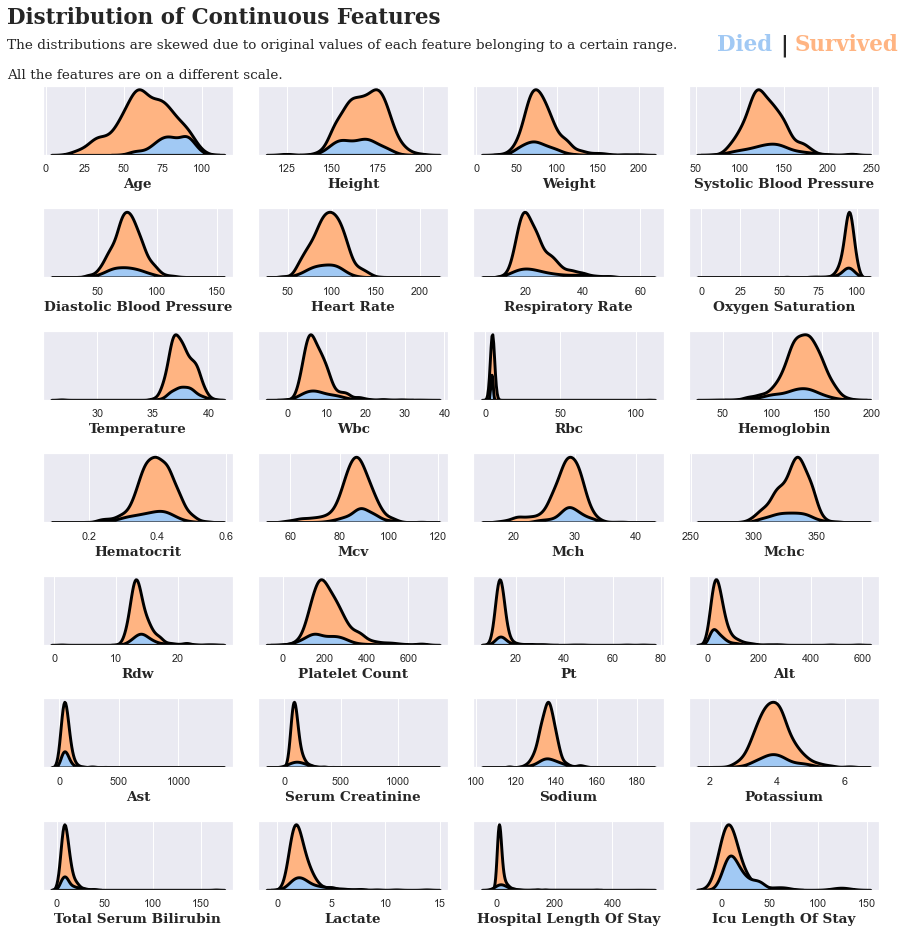

In [6576]:
fig,ax = plt.subplots(nrows = 7, ncols = 4, figsize = (13,13), dpi=70)
#fig.patch.set_facecolor(colors[-1])
axes = ax.ravel()

colors = ['#a1c9f4','#ffb482']


for col,ax in zip(numerical_cols,axes):
    
    ## plots
    
    sns.kdeplot(df[col], ax = ax, shade = True ,
                palette = [colors[0], colors[1]],
                alpha = 1, linewidth = 3, ec = 'black',
                hue = df['did_the_patient_die_in_hospital'],
                legend = False)
    
    ## plot setting
    xlabel = ' '.join([value.capitalize() for value in str(col).split('_') ])
    #ax.set_facecolor(colors[-1])
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.set_xlabel(xlabel,{'font':'serif','size':14, 'weight':'bold'}, alpha = 1)
   

    
plt.tight_layout(pad= 3,h_pad = 1.5, w_pad = 1.5)


## titles and text
fig.text(0,1.03,'Distribution of Continuous Features', {'font':'serif','size':22, 'weight':'bold'}, alpha = 1)
fig.text(0,0.97,'''The distributions are skewed due to original values of each feature belonging to a certain range.
\nAll the features are on a different scale.''',{'font':'serif','size':14, 'weight':'normal'}, alpha = 1)

fig.text(0.78,1, "Died",{'font':'serif','size':22, 'weight':'bold', 'color':colors[0]}, alpha = 1)
fig.text(0.85,1, '|',{'font':'serif','size':22, 'weight':'bold'})
fig.text(0.865,1, "Survived",{'font':'serif','size':22, 'weight':'bold','color':colors[1]}, alpha = 1)

fig.show()

All the continuous features have to normalized or standardized to fit in the same scale. It will help the models to understand the distribution better.

### Multivariate Analysis

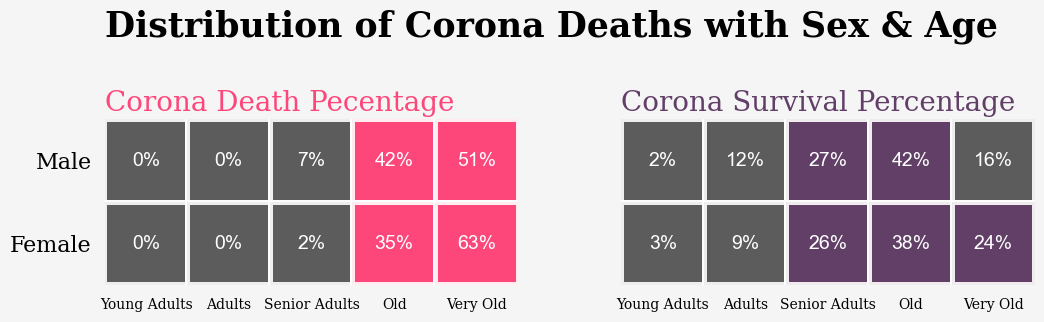

In [6577]:
fig = plt.figure(figsize=(12,6), dpi = 100)
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

fig.patch.set_facecolor('#f6f5f5')
ax0.set_facecolor('#f6f5f5')
ax1.set_facecolor('#f6f5f5')


survived = df[df['did_the_patient_die_in_hospital']== 'No']
dead = df[df['did_the_patient_die_in_hospital']== 'Yes']

disease_order = ['Male','Female']
age_order = ['Young Adults', 'Adults', 'Senior Adults', 'Old', 'Very Old']


col1 = ["#4b4b4c","#fe346e"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1, N = 256)
col2 = ["#4b4b4c","#512b58"]
colormap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", col2)

survived = pd.crosstab(survived['sex'],[survived['age_bins']],normalize='index').loc[disease_order,age_order]
dead = pd.crosstab(dead['sex'],[dead['age_bins']], normalize='index')
dead = dead.reindex(columns=['Young Adults', 'Adults', 'Senior Adults', 'Old', 'Very Old'], fill_value=0).loc[disease_order,age_order]


sns.heatmap(ax=ax0, data=dead, linewidths= 0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, cmap = col1,annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)

sns.heatmap(ax=ax1, data=survived, linewidths=0, 
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, cmap = col2,annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)


ax0.text(0, -1., 'Distribution of Corona Deaths with Sex & Age', {'font':'Serif', 'color':'black', 'weight':'bold','size':25})

ax0.text(0,-0.1,'Corona Death Pecentage ', {'font':'serif', 'color':"#fe346e", 'size':20},alpha = 0.9)
ax1.text(0,-0.1,'Corona Survival Percentage', {'font':'serif', 'color':"#512b58", 'size':20}, alpha =0.9)

ax0.axes.set_xticklabels(age_order, {'font':'serif', 'color':'black', 'size':10})
ax1.axes.set_xticklabels(age_order, {'font':'serif', 'color':'black', 'size':10})

ax0.axes.set_yticklabels(['Male','Female'], {'font':'serif', 'color':'black', 'size':16}, rotation = 0)

ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axes.get_yaxis().set_visible(False)
fig.show()

<div class="alert alert-block alert-info"> 📌 Very Old females (more than 80 years old) are more likely to die due to Covid when admitted to the hospital compared to younger females.
   </div>

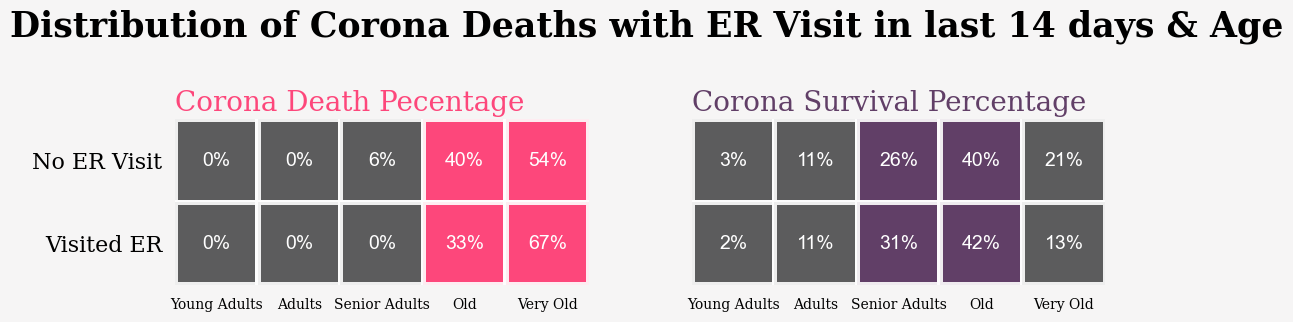

In [6578]:
fig = plt.figure(figsize=(12,6), dpi = 100)
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

fig.patch.set_facecolor('#f6f5f5')
ax0.set_facecolor('#f6f5f5')
ax1.set_facecolor('#f6f5f5')


survived = df[df['did_the_patient_die_in_hospital']== 'No']
dead = df[df['did_the_patient_die_in_hospital']== 'Yes']

disease_order = ['No','Yes']
age_order = ['Young Adults', 'Adults', 'Senior Adults', 'Old', 'Very Old']


col1 = ["#4b4b4c","#fe346e"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1, N = 256)
col2 = ["#4b4b4c","#512b58"]
colormap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", col2)

survived = pd.crosstab(survived['previous_er_visit_within_14_days'],[survived['age_bins']],normalize='index').loc[disease_order,age_order]
dead = pd.crosstab(dead['previous_er_visit_within_14_days'],[dead['age_bins']], normalize='index')
dead = dead.reindex(columns=['Young Adults', 'Adults', 'Senior Adults', 'Old', 'Very Old'], fill_value=0).loc[disease_order,age_order]


sns.heatmap(ax=ax0, data=dead, linewidths= 0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, cmap = col1,annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)

sns.heatmap(ax=ax1, data=survived, linewidths=0, 
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, cmap = col2,annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)


ax0.text(-2, -1., 'Distribution of Corona Deaths with ER Visit in last 14 days & Age', {'font':'Serif', 'color':'black', 'weight':'bold','size':25})

ax0.text(0,-0.1,'Corona Death Pecentage ', {'font':'serif', 'color':"#fe346e", 'size':20},alpha = 0.9)
ax1.text(0,-0.1,'Corona Survival Percentage', {'font':'serif', 'color':"#512b58", 'size':20}, alpha =0.9)

ax0.axes.set_xticklabels(age_order, {'font':'serif', 'color':'black', 'size':10})
ax1.axes.set_xticklabels(age_order, {'font':'serif', 'color':'black', 'size':10})

ax0.axes.set_yticklabels(['No ER Visit','Visited ER'], {'font':'serif', 'color':'black', 'size':16}, rotation = 0)

ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axes.get_yaxis().set_visible(False)
fig.show()

ER Visits in the last 14 days combined with age is not a very clear indicator of Covid deaths among the patients

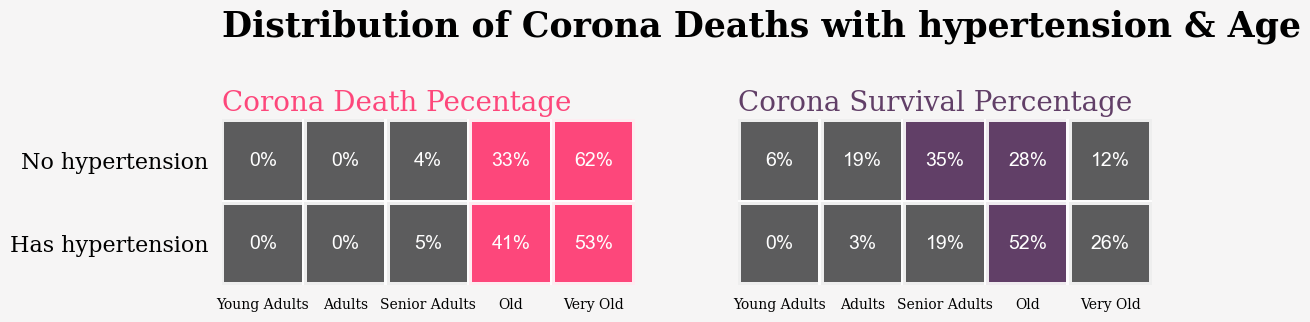

In [6579]:
comorbidities_df = pd.merge(comorbidities_df, df[['age_bins']], left_index = True, right_index = True, how = 'inner')
# import matplotlib

fig = plt.figure(figsize=(12,6), dpi = 100)
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

fig.patch.set_facecolor('#f6f5f5')
ax0.set_facecolor('#f6f5f5')
ax1.set_facecolor('#f6f5f5')


survived = comorbidities_df[comorbidities_df['did_the_patient_die_in_hospital']== 'No']
dead = comorbidities_df[comorbidities_df['did_the_patient_die_in_hospital']== 'Yes']

disease_order = [0, 1]
age_order = ['Young Adults', 'Adults', 'Senior Adults', 'Old', 'Very Old']


col1 = ["#4b4b4c","#fe346e"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1, N = 256)
col2 = ["#4b4b4c","#512b58"]
colormap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", col2)

survived = pd.crosstab(survived['hypertension'],[survived['age_bins']],normalize='index').loc[disease_order,age_order]
dead = pd.crosstab(dead['hypertension'],[dead['age_bins']], normalize='index')
dead = dead.reindex(columns=['Young Adults', 'Adults', 'Senior Adults', 'Old', 'Very Old'], fill_value=0).loc[disease_order,age_order]


sns.heatmap(ax=ax0, data=dead, linewidths= 0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, cmap = col1,annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)

sns.heatmap(ax=ax1, data=survived, linewidths=0, 
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, cmap = col2,annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)


ax0.text(0, -1., 'Distribution of Corona Deaths with hypertension & Age', {'font':'Serif', 'color':'black', 'weight':'bold','size':25})

ax0.text(0,-0.1,'Corona Death Pecentage ', {'font':'serif', 'color':"#fe346e", 'size':20},alpha = 0.9)
ax1.text(0,-0.1,'Corona Survival Percentage', {'font':'serif', 'color':"#512b58", 'size':20}, alpha =0.9)

ax0.axes.set_xticklabels(age_order, {'font':'serif', 'color':'black', 'size':10})
ax1.axes.set_xticklabels(age_order, {'font':'serif', 'color':'black', 'size':10})

ax0.axes.set_yticklabels(['No hypertension','Has hypertension'], {'font':'serif', 'color':'black', 'size':16}, rotation = 0)

ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axes.get_yaxis().set_visible(False)
fig.show()

Hypertension has no clear indication of Covid deaths among patients who are being admitted to the hospital.

# Building a model

To build a machine learning model to predict if a COVID patient is likely to die when admitted to the hospital, the following steps must be undertaken,

1. Data Preprocessing
2. Feature Engineering
3. Feature Selection
4. Handling Class Imbalance and Metric Selection
5. Model Selection
6. Hyperparameter Tuning
7. Performance Evaluation of the Best Model
8. Model Explainability

## Data Preprocessing

There are several steps to be done in preprocessing this data,

1. Handling Outliers
2. Train Test Split
3. Encoding Categorical Features
4. Handling Missing Values


### Handling Outliers:

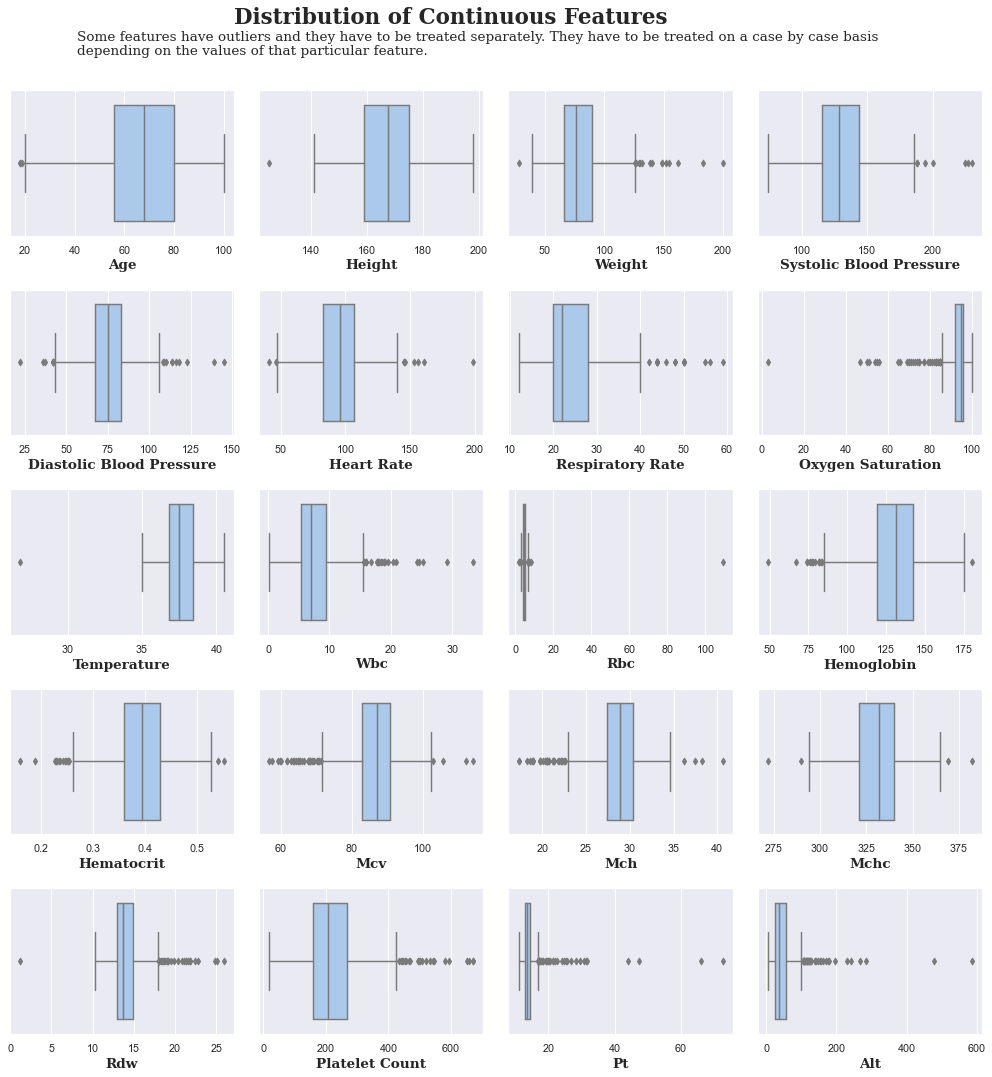

In [6580]:
fig,ax = plt.subplots(nrows = 5, ncols = 4, figsize = (15,15), dpi=70)
#fig.patch.set_facecolor(colors[-1])
axes = ax.ravel()

colors = ['#a1c9f4','#ffb482']

numerical_columns = list(df.select_dtypes(include = ['int64','float64']))

for col,ax in zip(numerical_columns,axes):
    
    ## plots
    
    sns.boxplot(df[col], ax = ax ,
                palette = [colors[0], colors[1]])
    
    ## plot setting
    xlabel = ' '.join([value.capitalize() for value in str(col).split('_') ])
    #ax.set_facecolor(colors[-1])
    ax.axes.get_yaxis().set_visible(False)
    ax.axes.set_xlabel(xlabel,{'font':'serif','size':14, 'weight':'bold'}, alpha = 1)
   

    
plt.tight_layout(pad= 3,h_pad = 1.5, w_pad = 1.5)


## titles and text
fig.text(0.25,1.03,'Distribution of Continuous Features', {'font':'serif','size':22, 'weight':'bold'}, alpha = 1)
fig.text(0.1,1.0,'''Some features have outliers and they have to be treated separately. They have to be treated on a case by case basis \ndepending on the values of that particular feature.''',{'font':'serif','size':14, 'weight':'normal'}, alpha = 1)

# fig.text(0.61,1, "Died",{'font':'serif','size':22, 'weight':'bold', 'color':colors[0]}, alpha = 1)
# fig.text(0.70,1, '|',{'font':'serif','size':22, 'weight':'bold'})
# fig.text(0.74,1, "Survived",{'font':'serif','size':16, 'weight':'bold','color':colors[1]}, alpha = 1)

fig.show()

Handling outliers is very subjective in this particular dataset. We have to handle this by a case by case basis depending on the values of that particular feature. In general we can group them into two,

    1. Individual Points which are anamalous from the entire group of values
    2. Clustered data points which are above the upper or lower bound of the IQR. These can be treated as normal values instead of examples. 
    
For case1 , in the above box, consider the plot of RBC where there is one value which is way out of proportion which can be treated as an outlier.

For case 2, in the above box plot, consider the plot of platelet counts where there are no few anamalous data points instead it is clustered together. In practise, the platelet count ranging from 150 - 400 * 10^9 /L are considered normal and values above 400 * 10^9/L are considered to be high and it is a medical condition called thrombocytosis. Such values can be treated as normal values. 

Based on our above assumptions, the following features can be grouped into bucket 1,

    1. Oxygen Saturation
    2. Heart rate
    3. Temperature
    4. RBC
    5. Alt
    6. Rdw
    7. Sodium
    8. Serum Creatine
    

To further verify our assumptions, take the case of oxygen saturation for example,

In [6581]:
def analyze_distribution(df, column):
    
    fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))
    #fig.patch.set_facecolor(colors[-1])
    axes = ax.ravel()
    
    print("Minimum value:", min(df[column]))
    print("Maximum value:",  max(df[column]))
    print("Mean value:", df[column].mean())
    print("Median value:", df[column].median())
    sns.histplot(data = df, x = column , palette="pastel", ax = axes[0])
    sns.boxplot(data = df, x = column , palette = "pastel", ax = axes[1])

Minimum value: 3.0
Maximum value: 100.0
Mean value: 93.17800289435601
Median value: 95.0


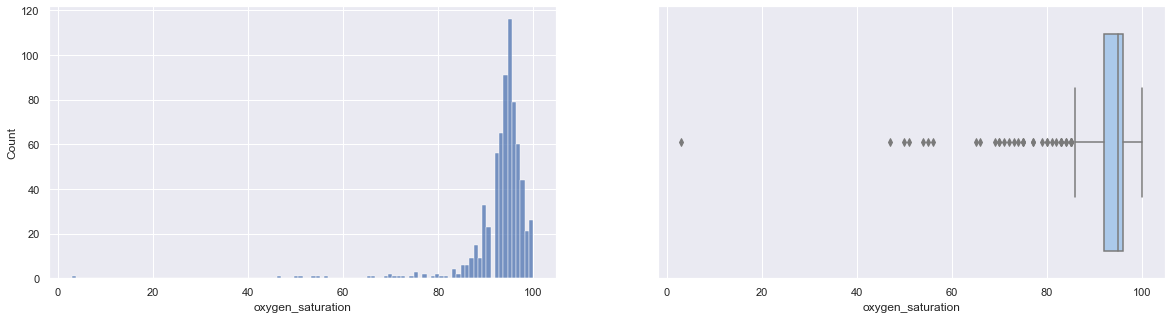

In [6582]:
analyze_distribution(df, 'oxygen_saturation')

As the lung infection increases due to Covid-19, the oxygen saturation level starts falling below the normal range (95% or more) and this is one of the main indicators for the person to be hospitalized. So apart from the minimum value 3, all the other oxygen saturation levels are valid and cannot be flagged as outliers. Infact it can be one of the main indicators for a person to die with Covid-19. The patient with the oxygen saturation value of 3 was most likely to be dead while being admitted. Let's explore that patient's data,

In [6583]:
oxygen_anamoly = df[df['oxygen_saturation'] == 3.0]
oxygen_anamoly

,age,sex,height,weight,comorbidities,smoking_history,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,...,lactate,did_the_patient_die_in_hospital,hospital_length_of_stay,icu_length_of_stay,days_in_hospital_prior_to_icu_admission,time_on_mechanical_ventilation,days_in_hospital_prior_to_mechanical_ventilation,age_bins,platelet_bins,wbc_bins
693,59,Male,NaN,NaN,['Other'],Non-smoker,No,WARD,132.0,87.0,...,NaN,No,3,NaN,NaN,NaN,NaN,Senior Adults,Normal Range,Normal Range


**The person survived and it's most likely a data entry error and we have to remove it.**

Let's consider the case of Serum Creatinine.

Minimum value: 30.0
Maximum value: 1179.0
Mean value: 115.36722306525039
Median value: 93.0


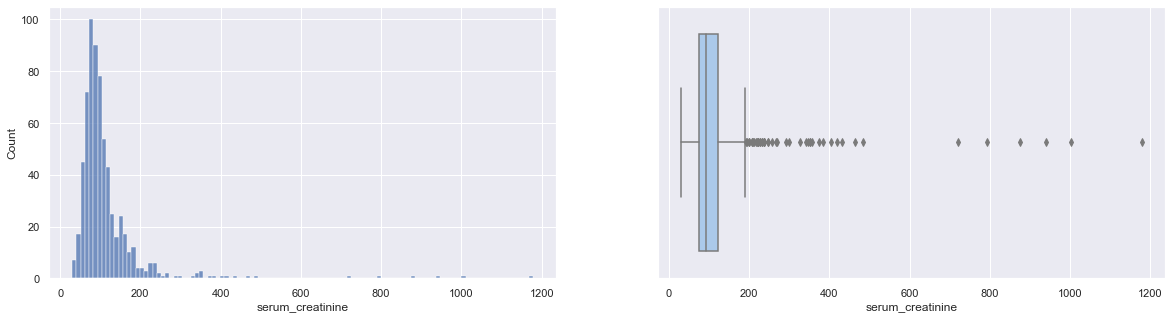

In [6584]:
analyze_distribution(df, 'serum_creatinine')

There are few anamolous outliers above a certain value (700) and they can be ignored for our analysis.

Let's try to use IQR to idenitfy the outliers

In [6585]:
Q1 = df.quantile(0.25)             #To find the 25th percentile and 75th percentile.
Q3 = df.quantile(0.75)
IQR = Q3 - Q1                           #Inter Quantile Range (75th perentile - 25th percentile)
lower=Q1-1.5*IQR                        #Finding lower and upper bounds for all values. All values outside these bounds are outliers
upper=Q3+1.5*IQR

print("# of values lying outide the upper and lower limits")
((df[numerical_columns]<lower) | (df[numerical_columns]>upper)).sum()

# of values lying outide the upper and lower limits


age                                                  3
height                                               1
weight                                              15
systolic_blood_pressure                              7
diastolic_blood_pressure                            17
heart_rate                                           9
respiratory_rate                                    18
oxygen_saturation                                   38
temperature                                          1
wbc                                                 25
rbc                                                 14
hemoglobin                                          16
hematocrit                                          17
mcv                                                 36
mch                                                 38
mchc                                                 4
rdw                                                 30
platelet_count                                      22
pt        

We can't use IQR to remove the outliers for the following reasons,

 1. The dataset is small and it's an highly imbalanced dataset. Using IQR to remove the rows might end up in creating further imbalance and loss of valubale data.
 2. Since this is a patient dataset, it is highly subjective and it is possible to have values lying outside the upper and lower limit of the IQR.
 
The solution here is to remove outliers which may be during due to data entry errors and device reading errors by manually looking at the box plots. For large scale datasets, we can choose more sophisticated methods like **Isolation forests** to flag the outliers.

In [6586]:
def remove_value_from_df(df, column, value):
    '''Removes a row from the dataframe based on matching values'''
    return df[df[column]!= value]

In [6587]:
# removing outliers from columns
df = remove_value_from_df(df, 'rbc', max(df['rbc']))
df = remove_value_from_df(df, 'temperature', min(df['temperature']))
df = remove_value_from_df(df, 'oxygen_saturation', min(df['oxygen_saturation']))
df = remove_value_from_df(df, 'rdw', min(df['rdw']))
df = remove_value_from_df(df, 'alt', max(df['alt']))
df = remove_value_from_df(df, 'alt', min(df['alt']))
df = remove_value_from_df(df, 'heart_rate', max(df['heart_rate']))
df = remove_value_from_df(df, 'sodium', max(df['sodium']))
df = df[df['serum_creatinine'] < 700]

We can also remove the features which were calculated for our analysis and the features which were collected after the death of the patient

In [6588]:
df = df.drop(['hospital_length_of_stay',
       'icu_length_of_stay', 'days_in_hospital_prior_to_icu_admission',
       'time_on_mechanical_ventilation',
       'days_in_hospital_prior_to_mechanical_ventilation', 'age_bins',
       'platelet_bins', 'wbc_bins' ], axis = 1)

In [6589]:
print("Dataset shape after removing outliers:")
print("# of rows:", df.shape[0] )
print("# of columns:", df.shape[1])

Dataset shape after removing outliers:
# of rows: 647
# of columns: 36


In [6590]:
# Let's convert our target variable into 1's and 0's before the next processing step.

def convert_label(x):
    ''' Asigns 0 or 1 to the target variable'''
    if x == 'Yes':
        return 1
    else:
        return 0
    
df['did_the_patient_die_in_hospital'] = df['did_the_patient_die_in_hospital'].apply(lambda x: convert_label(x))

### Train Test Split

The dataset can be divided into the train and test set with 80% - 20% split using the stratified approach.

In [6591]:
X = df.drop(['did_the_patient_die_in_hospital'],axis=1)
y = df['did_the_patient_die_in_hospital'].astype('category')

In [6592]:
# Train testv split
X_train ,X_test ,y_train ,y_test = train_test_split(X, y, test_size = 0.20, random_state = 26, stratify = y)
print("Number of rows in train data:", X_train.shape[0])
print("Distribution of target variable in train set:")
print(y_train.value_counts())
print("Number of rows in test data:", X_test.shape[0])
print("Distribution of target variable in test set:")
print(y_test.value_counts())

Number of rows in train data: 517
Distribution of target variable in train set:
0    434
1     83
Name: did_the_patient_die_in_hospital, dtype: int64
Number of rows in test data: 130
Distribution of target variable in test set:
0    109
1     21
Name: did_the_patient_die_in_hospital, dtype: int64


### Handling Missing Values

Let's explore the distribution of the missing values in the dataset

Missing Cells: 1865
Missing Cells(%): 10.31%
# of features with missing values: 32
# of features with more than 30% of missing values: 6


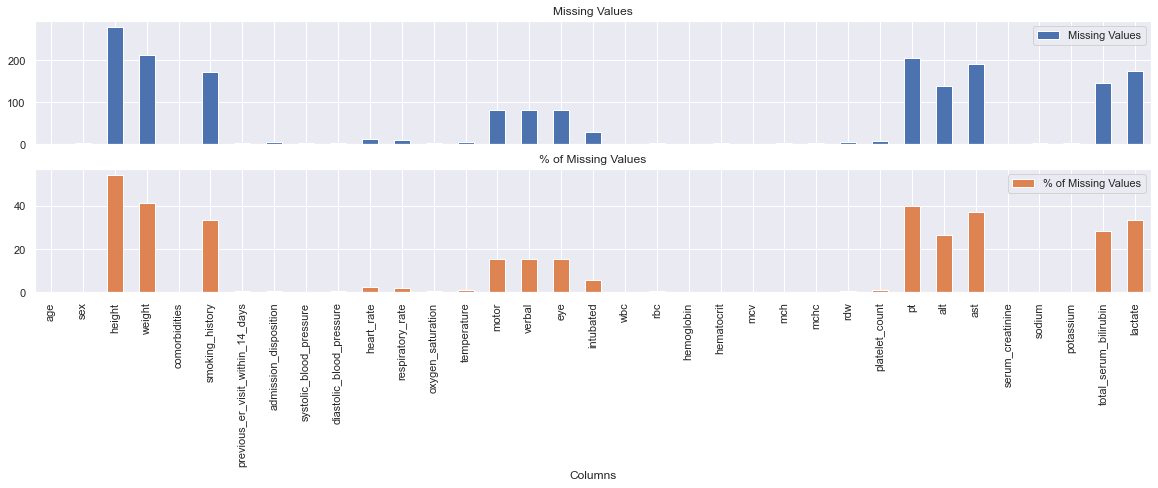

In [6593]:
missing_data_distribution = missing_data_statistics(X_train, return_stats_df = True, plot = True, threshold = 30)

Based on the industry standards, we can drop the features with more than 30% of missing values. We can explore different imputation strategies for columns with less than 30%.

In [6594]:
more_than_30_percent = missing_data_distribution[missing_data_distribution['% of Missing Values'] > 30]
columns_to_remove = more_than_30_percent['Columns'].values.tolist()

# Manually adding the feature 'alt' which has 29.82% of missing values
columns_to_remove = columns_to_remove + ['alt']

X_train = X_train.drop(columns_to_remove, axis = 1)
X_test = X_test.drop(columns_to_remove, axis = 1)

print("# of columns removed", len(columns_to_remove))
more_than_30_percent

# of columns removed 7


,Columns,Missing Values,% of Missing Values
2,height,281,54.35
3,weight,213,41.20
5,smoking_history,172,33.27
27,pt,206,39.85
29,ast,192,37.14
34,lactate,174,33.66


In [6595]:
X_train.head()

,age,sex,comorbidities,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,...,hematocrit,mcv,mch,mchc,rdw,platelet_count,serum_creatinine,sodium,potassium,total_serum_bilirubin
355,79,Male,"['Chronic cardiac disease (not hypertension)',...",No,WARD,101.0,78.0,70.0,20.0,94.0,...,0.458,88.2,29.1,330.0,14.5,195.0,94.0,138.0,4.1,22.0
338,82,Male,"['Chronic cardiac disease (not hypertension)',...",Yes,WARD,112.0,51.0,63.0,28.0,95.0,...,0.390,99.0,30.5,308.0,14.4,192.0,167.0,136.0,4.5,NaN
83,64,Female,['Other'],No,WARD,175.0,60.0,113.0,22.0,96.0,...,0.360,90.9,29.0,319.0,13.1,316.0,72.0,137.0,3.6,7.0
580,49,Male,[],No,WARD,106.0,68.0,80.0,16.0,93.0,...,0.386,86.9,30.0,346.0,13.2,169.0,84.0,136.0,3.8,11.0
323,92,Male,"['Chronic pulmonary (lung) disease', 'Dementia...",No,WARD,137.0,64.0,55.0,18.0,99.0,...,0.456,87.2,27.7,318.0,15.0,158.0,79.0,146.0,3.4,10.0


There are certain values in the comorbidities column which had empty lists. This might be due to possible reasons,

    1. The person has no comorbidity and perfectly healthy
    2. It might be due to a missing data point.
    
 We can assume that the person has no comorbidity and flag it as a new value

In [6596]:
X_train.loc[X_train['comorbidities'] == '[]', 'comorbidities' ] = "['No Comorbidity']"
X_test.loc[X_test['comorbidities'] == '[]', 'comorbidities' ] = "['No Comorbidity']"

We can follow 2 strategies to impute the missing values,

1. For categorical features, we can impute with the most frequent value.
2. For numerical features,  we can impute using the median value.

In [6597]:
categorical_columns = list(X_train.select_dtypes(['category','O']))
print("Distribution of missing values in the categorical columns:")
categorical_missing = missing_data_statistics(X_train[categorical_columns], True, plot = False)
categorical_missing

Distribution of missing values in the categorical columns:
Missing Cells: 281
Missing Cells(%): 6.79%
# of features with missing values: 7
# of features with more than 30% of missing values: 0


,Columns,Missing Values,% of Missing Values
0,sex,2,0.39
2,previous_er_visit_within_14_days,3,0.58
3,admission_disposition,4,0.77
4,motor,81,15.67
5,verbal,81,15.67
6,eye,81,15.67
7,intubated,29,5.61


In [6598]:
numerical_columns = list(X_train.select_dtypes(['int64','float64']))
print("Distribution of missing values in the categorical columns:")
numerical_missing = missing_data_statistics(X_train[numerical_columns], True, plot = False)
numerical_missing

Distribution of missing values in the categorical columns:
Missing Cells: 208
Missing Cells(%): 2.01%
# of features with missing values: 18
# of features with more than 30% of missing values: 0


,Columns,Missing Values,% of Missing Values
1,systolic_blood_pressure,2,0.39
2,diastolic_blood_pressure,3,0.58
3,heart_rate,12,2.32
4,respiratory_rate,10,1.93
5,oxygen_saturation,3,0.58
6,temperature,5,0.97
7,wbc,1,0.19
8,rbc,3,0.58
9,hemoglobin,1,0.19
10,hematocrit,2,0.39


In [6599]:
# Imputation of Categorical columns
mode_imputed_col = categorical_missing['Columns'].values.tolist()

for column in mode_imputed_col:
    column_mode = X_train[column].mode()
    X_train[column] = X_train[column].fillna(column_mode[0])
    X_test[column] = X_test[column].fillna(column_mode[0])

In [6600]:
# Imputation of Numerical columns

median_imputed_col = numerical_missing['Columns'].values.tolist()

for column in median_imputed_col:
    column_median = X_train[column].median()
    X_train[column] = X_train[column].fillna(column_median)
    X_test[column] = X_test[column].fillna(column_median)

In [6601]:
print(X_train.isnull().sum())

age                                 0
sex                                 0
comorbidities                       0
previous_er_visit_within_14_days    0
admission_disposition               0
systolic_blood_pressure             0
diastolic_blood_pressure            0
heart_rate                          0
respiratory_rate                    0
oxygen_saturation                   0
temperature                         0
motor                               0
verbal                              0
eye                                 0
intubated                           0
wbc                                 0
rbc                                 0
hemoglobin                          0
hematocrit                          0
mcv                                 0
mch                                 0
mchc                                0
rdw                                 0
platelet_count                      0
serum_creatinine                    0
sodium                              0
potassium   

Now that we have handled the missing data, we can proceed to feature engineering

## Feature Engineering

The comorbidities can be expanded into their individual values. We can use the same function we used to perform this expansion during our analysis.

In [6602]:
print("# of features in the training data before expansion", X_train.shape[1])
X_train = expand_columns_with_list(X_train, 'comorbidities')
print("# of features in the training data after expansion", X_train.shape[1])

# of features in the training data before expansion 28
Correct expanded rows: 517
Incorrectly expanded rows: 0
The column has been expanded without any errors
# of features in the training data after expansion 46


In [6603]:
print("# of features in the test data before expansion", X_test.shape[1])
X_test = expand_columns_with_list(X_test, 'comorbidities')
print("# of features in the test data after expansion", X_test.shape[1])

# of features in the test data before expansion 28
Correct expanded rows: 130
Incorrectly expanded rows: 0
The column has been expanded without any errors
# of features in the test data after expansion 45


In [6604]:
# To handle any disease not present in the test data
X_train, X_test = X_train.align(X_test, join='left', axis=1)
no_data_columns = X_test.columns[X_test.isnull().any()]
for column in no_data_columns:
    X_test[column] = 0

In [6605]:
# Encoding of categorical features
only_categorical_train = X_train.select_dtypes(include=['object', 'category'])
only_categorical_test = X_test.select_dtypes(include=['object', 'category'])
only_categorical_train_expanded = pd.get_dummies(only_categorical_train)
only_categorical_test_expanded = pd.get_dummies(only_categorical_test)

# Align the number of features across the test sets based on train dataset
only_categorical_train_expanded, only_categorical_test_expanded = only_categorical_train_expanded.align(only_categorical_test_expanded, join='left', axis=1)
only_categorical_test_expanded = only_categorical_test_expanded.fillna(0)
for column in list(only_categorical_test_expanded.columns):
    only_categorical_test_expanded[column] = only_categorical_test_expanded[column].apply('uint8')
    
# Remove original features and retain only encoded features
X_train = X_train.drop(list(only_categorical_train.columns), axis = 1)
X_test = X_test.drop(list(only_categorical_test.columns), axis = 1)
X_train = pd.merge(X_train,only_categorical_train_expanded, left_index = True, right_index = True )
X_test = pd.merge(X_test,only_categorical_test_expanded, left_index = True, right_index = True )

In [6606]:
scaler = StandardScaler()

# get numeric data
only_numerical_train = X_train.select_dtypes(exclude=['object', 'category'])
only_numerical_test = X_test.select_dtypes(exclude=['object', 'category'])

# update the cols with their normalized values
X_train[only_numerical_train.columns] = scaler.fit_transform(only_numerical_train)

X_test[only_numerical_test.columns] = scaler.transform(only_numerical_test)

## Feature Selection

Feature Selection is an iterative process and we can treat this as a 2 step process,

    1.Selecting the top 20 features using mutual_info_classif (K-Best Feature Selector)
    2.Selecting the top n features using Recursive Feature Elimination method


### Selecting the top 20 features using mutual info classifier method:


In [6607]:
np.random.seed(1)

feature_selector = SelectKBest(score_func = mutual_info_classif, k = 20)
feature_selector.fit(X_train, y_train)

feature_columns = X_train.columns
feature_list = []
for i in range(len(feature_selector.scores_)):
    feature_list.append([feature_columns[i],feature_selector.scores_[i]])
feature_df = pd.DataFrame(feature_list)
feature_df = feature_df.sort_values(1,ascending=False)
feature_df.columns = ['feature','score']
print("Top 20 Features with their scores")
feature_df[:20]

Top 20 Features with their scores


,feature,score
19,age,0.095220
10,hypertension,0.047887
15,other,0.041906
2,chronic_cardiac_disease,0.034424
57,eye_2.0,0.034045
23,respiratory_rate,0.033911
5,chronic_renal,0.033816
1,cancer,0.031820
59,eye_4.0,0.031038
54,verbal_4.0,0.030814


In [6608]:
selected_columns = feature_df['feature'].values.tolist()[:20]
X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]

In [6609]:
print('Top 20 features:', selected_columns)

Top 20 features: ['age', 'hypertension', 'other', 'chronic_cardiac_disease', 'eye_2.0', 'respiratory_rate', 'chronic_renal', 'cancer', 'eye_4.0', 'verbal_4.0', 'asthma', 'total_serum_bilirubin', 'hemoglobin', 'chronic_neurological_disorder', 'motor_2.0', 'hematological', 'verbal_3.0', 'serum_creatinine', 'systolic_blood_pressure', 'verbal_5.0']


### Finalizing the features using Recursive Feature Elimination

In [6610]:
min_features_to_select = 1  # Minimum number of features to consider

# Logisitc regression model can be used as the base estimator
clf = LogisticRegression(random_state = 8)

# Perform k-fold cross validation and RFE to select the best features
cv = StratifiedKFold(5)
rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="recall",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train_selected, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 10


In [6611]:
selected_columns = X_train_selected.columns[rfecv.support_]
X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]

In [6612]:
print('Features selected for building the model:', selected_columns)

Features selected for building the model: Index(['age', 'hypertension', 'other', 'chronic_cardiac_disease',
       'respiratory_rate', 'chronic_renal', 'eye_4.0', 'verbal_4.0',
       'motor_2.0', 'systolic_blood_pressure'],
      dtype='object')


## Handling Class Imbalance

Since the dataset is a highly imbalanced dataset, we can use the oversampling technique using the SMOTE method to handle the imbalance data. This method oversamples the training dataset such that the number of target variable becomes equal (balanced) in the training dataset.

In [6613]:
print("Before UpSampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label 'No': {} \n".format(sum(y_train==0)))


sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 3, random_state=26)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train_selected, y_train)


print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over==0)))

print('After UpSampling, the shape of train features: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train target: {} \n'.format(y_train_over.shape))

Before UpSampling, counts of label 'Yes': 83
Before UpSampling, counts of label 'No': 434 

After UpSampling, counts of label 'Yes': 434
After UpSampling, counts of label 'No': 434 

After UpSampling, the shape of train features: (868, 10)
After UpSampling, the shape of train target: (868,) 



## Metric Selection

Our goal is to predict if a COVID patient is likely to die when admitted to the hospital. It is a binary classification problem. But our dataset is a highly imbalanced dataset. So accuracy cannot be used as the metric. To select the best metric, let's define the four different outcomes of our model.

Labels:

Died after admitted to the hospital:

Yes - 1
No - 0

1. True Positive (TP) - The model correctly predicts that a Covid-19 patient will die.
2. True Negative (TN) - The model correctly predicts that a Covid-19 patient will survive.
3. False Positive (FP) - The model predicts a Covid-19 patient is going to die when in reality the patient will survive.
4. False Negative (FN) - The model predicts a Covid-19 patient is going to survive when in reality the patient will die.

Out of all the predicted outcome types, the **False Negative** is the most dangerous to the performance of our model and the life of the patients. This will result in not giving proper treatment and care to the patients and can be detrimental. So our metric should optimize False Negatives. 

#### Selected Metric: Recall

Recall = TP/(TP + FN)

Recall gives us the percentage of patients who are correctly predicted as going to die among all the patients who are going to die due to Covid-19 in our dataset

## Model Selection

Since our dataset is a highly imbalanced dataset we need to select a model which handles class imbalance well.Model Interpretrabilty is also one of the main factors which plays a crucial role. The following 5 models are selected for our evaluation,

1. Logistic Regression (Baseline Performance and interpretable)
2. K Nearest Neighbors (Assigns labels based on characteristics of the nearest patients)
3. Decision Trees (Handles categorical data well and interpretable)
4. Random Forest (Handles categorical data well, reduces overfitting and interpretable)
5. XGBoost (Handles imbalanced data well, provides good results and interpretable)

We shall use the default hyperparameters to get the results and select the best model based on the performance.


In [6614]:
# Class to perform model training using cross validation and make predictions

class Model:
    def __init__(self,classifier, X_train, y_train, X_test, y_test, return_metrics = True, save_predictions = False):
        
        self.classifier = classifier
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.return_metrics = metrics
        self.save_predictions = save_predictions
        self.scorer = metrics.make_scorer(metrics.recall_score)

    def calculate_results(self, y_true, y_pred):
    
        # Calculate the results based on model's predictions
        print(metrics.classification_report(y_true, y_pred))

        scores = {}
        scores['accuracy'] = metrics.accuracy_score(y_true, y_pred)
        scores['f1_score'] = metrics.f1_score(y_true, y_pred)
        scores['precision'] = metrics.precision_score(y_true, y_pred)
        scores['recall'] = metrics.recall_score(y_true, y_pred)
        print("Recall:", scores['recall'])
        return scores

    def train_model(self):

        results = {}
        print("Training Model")
        # Perform K-fold cross validation
        kfold = StratifiedKFold(
            n_splits=5, shuffle=True, random_state=1
        )  # Setting number of splits equal to 5
        cv_result = cross_val_score(
            estimator=self.classifier, X=self.X_train, y=self.y_train, scoring = scorer,cv=kfold
        )

        self.classifier.fit(self.X_train, self.y_train)


        print("Training Cross Validation Score:", cv_result.mean() )
        y_train_pred = self.classifier.predict(self.X_train)
        print("Training Results:")
        results["train"] = self.calculate_results(self.y_train, y_train_pred)
        print("Making Predictions")
        y_pred = self.classifier.predict(self.X_test)
        print("Test Results:")
        results["test"] = self.calculate_results(self.y_test, y_pred)
        if self.return_metrics:
            return results
        if self.save_predictions:
            self.store_predictions(y_pred)

    def store_predictions(self, y_pred):
        # store predictions if necessary
        y_pred_df = pd.DataFrame(y_pred, columns = ['predictions'])
        predictions = pd.concat([self.X_test,y_pred_df],axis = 1)
        predictions.to_csv('predicted_results.csv',index = False)

#### Logistic Regression

In [6615]:
lr = LogisticRegression(random_state = 26)
lr_model = Model(lr, X_train_over, y_train_over, X_test_selected, y_test, return_metrics = True)
lr_model_results = lr_model.train_model()

Training Model
Training Cross Validation Score: 0.7949746057203957
Training Results:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       434
           1       0.74      0.78      0.76       434

    accuracy                           0.76       868
   macro avg       0.76      0.76      0.76       868
weighted avg       0.76      0.76      0.76       868

Recall: 0.7811059907834101
Making Predictions
Test Results:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       109
           1       0.36      0.76      0.48        21

    accuracy                           0.74       130
   macro avg       0.65      0.75      0.65       130
weighted avg       0.85      0.74      0.77       130

Recall: 0.7619047619047619


#### K Nearest Neighbors

In [6616]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn_model = Model(knn, X_train_over, y_train_over, X_test_selected, y_test, return_metrics = True)
knn_model_results = knn_model.train_model()

Training Model
Training Cross Validation Score: 0.9517241379310345
Training Results:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       434
           1       0.89      0.98      0.94       434

    accuracy                           0.93       868
   macro avg       0.94      0.93      0.93       868
weighted avg       0.94      0.93      0.93       868

Recall: 0.9815668202764977
Making Predictions
Test Results:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       109
           1       0.32      0.52      0.40        21

    accuracy                           0.75       130
   macro avg       0.61      0.66      0.62       130
weighted avg       0.80      0.75      0.77       130

Recall: 0.5238095238095238


#### XGBoost Classifier

In [6617]:
# Functions to clean column names for xgboost model

def clean_column_names(column):

    column = column.rstrip()
    column = re.sub(r'\[', '_', column)
    column = re.sub(r'\]','_', column)
    column = re.sub(r'\)','_', column)
    column = re.sub(r'\(','_', column)

    column = re.sub('  ',' ', column)

    return column.strip().lower().replace(' ', '_')

def xgboost_feature_preparation(X_train_over,X_test_selected ):

    X_train_xgover = X_train_over.copy()
    X_test_selected_xgover = X_test_selected.copy()
    for column in list(X_train_xgover.columns):
        X_train_xgover[column] = X_train_xgover[column].astype(int)
        X_test_selected_xgover[column] = X_train_xgover[column].astype(int)

    X_train_xgover.columns = [clean_column_names(column) for column in X_train_xgover.columns ]
    X_test_selected_xgover.columns = [clean_column_names(column) for column in X_test_selected_xgover.columns ]
    
    return X_train_xgover, X_test_selected_xgover

In [6618]:
X_train_xgover, X_test_selected_xgover = xgboost_feature_preparation(X_train_over,X_test_selected )

In [6619]:
xgb = XGBClassifier()
xgb_model = Model(xgb,X_train_xgover, y_train_over, X_test_selected_xgover, y_test, return_metrics = True)
xgb_model_results = xgb_model.train_model()

Training Model
Training Cross Validation Score: 0.7467789361133387
Training Results:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       434
           1       0.80      0.79      0.79       434

    accuracy                           0.79       868
   macro avg       0.79      0.79      0.79       868
weighted avg       0.79      0.79      0.79       868

Recall: 0.7880184331797235
Making Predictions
Test Results:
              precision    recall  f1-score   support

           0       0.82      0.58      0.68       109
           1       0.13      0.33      0.19        21

    accuracy                           0.54       130
   macro avg       0.48      0.46      0.43       130
weighted avg       0.71      0.54      0.60       130

Recall: 0.3333333333333333


#### Random Forest Classifier

In [6620]:
rfc = RandomForestClassifier()
rfc_model = Model(rfc,X_train_selected, y_train, X_test_selected, y_test, return_metrics = True)
rfc_model_results = rfc_model.train_model()

Training Model
Training Cross Validation Score: 0.16764705882352943
Training Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       434
           1       1.00      1.00      1.00        83

    accuracy                           1.00       517
   macro avg       1.00      1.00      1.00       517
weighted avg       1.00      1.00      1.00       517

Recall: 1.0
Making Predictions
Test Results:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       109
           1       0.29      0.10      0.14        21

    accuracy                           0.82       130
   macro avg       0.57      0.52      0.52       130
weighted avg       0.76      0.82      0.77       130

Recall: 0.09523809523809523


<div class="alert alert-block alert-info"> 📌 Based on the performance of all the models, it looks like the logistic regression is the best performing model with the highest recall score (76.19%). We can select the logistic regression model and tune it's hyperparameters to further improve it's results.
 </div>

## Hyperparameter Tuning

In [6649]:
# scorer for recall metric
np.random.seed(1)
scorer = metrics.make_scorer(metrics.recall_score)
parameters_grid = {    
    'C' : [0.01, 0.1, 1],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000] }

In [6642]:
logreg = LogisticRegression(random_state = 26)
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters_grid,   # hyperparameters
                   scoring = scorer,        # metric for scoring
                   cv = 10)                     # number of folds
clf.fit(X_train_over,y_train_over)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=26),
             param_grid={'C': [0.01, 0.1, 1],
                         'max_iter': [100, 1000, 2500, 5000],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                    'saga']},
             scoring=make_scorer(recall_score))

In [6643]:
print("Best Hyperparameters:", clf.best_params_)

Best Hyperparameters: {'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'}


In [6644]:
# Best model using the tuned hyperparameters
logreg = LogisticRegression(C = 0.01, 
                            penalty = 'l2', 
                            solver = 'liblinear',
                            max_iter = 100,
                            random_state = 26)
logreg.fit(X_train_over,y_train_over)
y_pred = logreg.predict(X_test_selected)
print("Recall Score for the test dataset: {}%".format(round(metrics.recall_score(y_test, y_pred)*100, 2)))

Recall Score for the test dataset: 80.95%


<div class="alert alert-block alert-info"> 📌📌 Hyperparameter tuning has improved the results of the Logistic Regression model. The final recall score for the best model is 80.95%.
 </div>

## Performance Evaluation

### Classification Report

In [6650]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.70      0.80       109
           1       0.34      0.81      0.48        21

    accuracy                           0.72       130
   macro avg       0.65      0.75      0.64       130
weighted avg       0.85      0.72      0.75       130



Our model achieves comparable performance in recall scores for both the target labels.

### Confusion Matrix

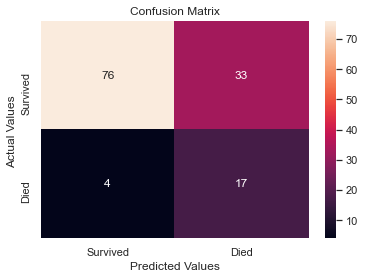

In [6651]:
# get confusion matrix
cf_matrix = metrics.confusion_matrix(y_test, y_pred)
#plot confusion matrix
ax = sns.heatmap(cf_matrix, annot=True)

# Set titles
ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

# Axis Labels
ax.xaxis.set_ticklabels(['Survived','Died'])
ax.yaxis.set_ticklabels(['Survived','Died'])

plt.show()

Selecting recall as the main metric for evaluation has helped the model to reduce the number of false negatives. This will help in saving the lives of patients.

## Model Explainability using SHAP

In [6652]:
explainer = shap.Explainer(logreg.predict, X_test_selected)
# Calculates the SHAP values
shap_values = explainer(X_test_selected)

Feature Importance using SHAP


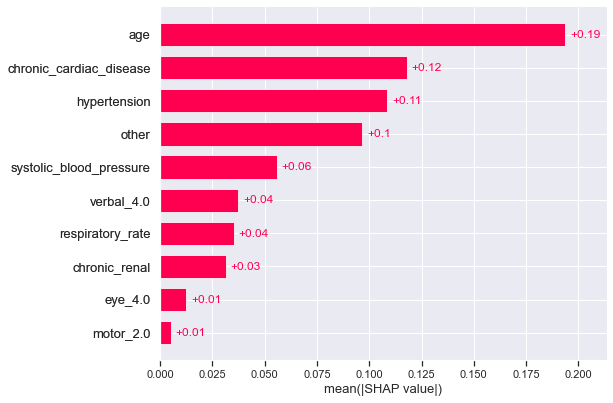

In [6653]:
print("Feature Importance using SHAP")
shap.plots.bar(shap_values)

SHAP gives us the feature importance for our model. Age is one of the best indicators of Covid deaths

# Conclusion and Summary


## Task 1: Exploration:

1) Explore the data to find any useful and interesting insights and visualizations

### Findings from the analysis:

📌 It is a highly imbalanced dataset with the labels distributed as 83% and 17%.

**Is age an indicator?**

📌 Based on our analysis, it is evident that age plays a crucial role and has big impact on the death of Covid-19 patients. People above 60 years old are more likely to die from Covid-19 when admitted to the hospital.


**Is low platelet count an indicator of Covid deaths?**

📌 Based on the visualizations, platelet count is an indicator of a Covid patient dying after being admitted to the hospital.

**Is WBC count an indicator of Covid deaths?**
 
📌 Based on our analysis, WBC count is not a clear indicator of Covid deaths.


**Bonus task: Out of the 18 comorbidities present in the patients, what are the top ones associated with death?**

📌📌 A single patient can have many comorbidities. Based on the analysis, the 3 most commonly occuring comorbidities which are associated with 118 patients who died after admitted are, 
1. Other comorbidities which are not listed in the sample
2. Hypertension
3. Diabetes

**But are these the deadlist comorbidities?**

📌📌 Comorbidities with the top 3 highest death rates: 

1. Chronic Neurological Disorder
2. Chronic Renal
3. Chronic Cardiac Disease 

Chronic Neurological Disorder, Chronic Renal and Chronic Cardiac Disease are the comorbidities with the top 3 highest death rates. It means that if a Covid patient is admitted to a hospital with one of these 3 comorbidities, the patient is more likely to die compared to patients who have only other comorbidities or only hyperension.

📌 People with more comorbidities are more like to die due to Covid after being admitted to the hospital.

📌 Chronic cardiac disease (not hypertension)', 'Hypertension', 'Diabetes', 'Other' comorbidity combination seems to have the highest death rate with atleast 10 deaths.


## Task 2: Building the model:

Build a machine learning model from this dataset that predicts if a COVID patient is likely to die when admitted to the hospital. 

📌 Model - Logistic Regression

📌 Recall Score - 80.95%

**What do you think is the best evaluation metric for this particular problem? explain.** 

### Selected Metric: Recall

Our goal is to predict if a COVID patient is likely to die when admitted to the hospital. It is a binary classification problem. But our dataset is a highly imbalanced dataset. So accuracy cannot be used as the metric. To select the best metric, let's define the four different outcomes of our model.

Labels:

Died after admitted to the hospital:

Yes - 1
No - 0

1. True Positive (TP) - The model correctly predicts that a Covid-19 patient will die.
2. True Negative (TN) - The model correctly predicts that a Covid-19 patient will survive.
3. False Positive (FP) - The model predicts a Covid-19 patient is going to die when in reality the patient will survive.
4. False Negative (FN) - The model predicts a Covid-19 patient is going to survive when in reality the patient will die.

Out of all the predicted outcome types, the **False Negative** is the most dangerous to the performance of our model and the life of the patients. This will result in not giving proper treatment and care to the patients and can be detrimental. So our metric should optimize False Negatives. Hence, **Recall** is the best metric for this model.


Recall = TP/(TP + FN)

Recall gives us the percentage of patients who are correctly predicted as going to die among all the patients who are going to die due to Covid-19 in our dataset


## Future Steps:

1. Handling outliers using advanced methods like Isolation Forest.
2. Using KNearestNeighbors Imputation method to impute the missing values.
3. Use Class weights to handle the class imbalance of the model.
4. Use AutoML solutions to compare the performance.
5. Creating data preprocessing and model pipelines.
6. Perform further hyperparameter tuning to improve the performance of the model.